In [1522]:
# Libraries for data manipulation, cleaning, and basic analysis
import pandas as pd
import numpy as np

# For static visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
from PIL import Image

# For generating word clouds
from wordcloud import WordCloud
from folium.plugins import HeatMap
from IPython.display import display

# For handling geospatial data
import geopandas as gpd  # For geospatial data operations
from shapely.geometry import Point  # For creating geometry objects for maps
import folium  # For creating interactive maps
from folium.plugins import HeatMap  # Heatmap for density plotting on maps
from folium.plugins import MarkerCluster

# To suppress warnings that may clutter the output
import warnings
warnings.filterwarnings("ignore")

In [1523]:
data = pd.read_csv("GTD dataset.csv", encoding='ISO-8859-1')

In [1524]:
df = data.copy()

In [1525]:
df.head()

,eventid,iyear,imonth,iday,extended,provstate,city,latitude,longitude,location,...,weapdetail,nkill,nwound,nkillter,nwoundte,property,propextent,propextent_txt,propvalue,propcomment
0,1.980000e+11,1975,3,25,1,Banaadir,Mogadishu,2.059819,45.326115,NaN,...,NaN,0.0,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN
1,1.980000e+11,1980,4,0,0,Banaadir,Mogadishu,2.059819,45.326115,NaN,...,NaN,1.0,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN
2,1.980000e+11,1981,1,0,0,Banaadir,Mogadishu,2.059819,45.326115,NaN,...,Explosive,0.0,2.0,NaN,NaN,1,NaN,NaN,NaN,NaN
3,1.980000e+11,1981,1,0,0,Banaadir,Mogadishu,2.059819,45.326115,NaN,...,Explosive,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
4,1.980000e+11,1981,1,0,0,Banaadir,Mogadishu,2.059819,45.326115,NaN,...,Explosive,NaN,NaN,NaN,NaN,1,4.0,Unknown,NaN,NaN


## **Data Cleaning**

#### **Renaming the columns**

In [1526]:
# Clean columns by renaming them
df.rename(columns={
    'iyear': 'year', 'imonth': 'month', 'iday': 'day', 'success': 'success', 'suicide': 'suicide',
    'provstate': 'region', 'city': 'city', 'latitude': 'lat', 'longitude': 'long', 'summary': 'summary',
    'attacktype1_txt': 'attack_type', 'targtype1_txt': 'target_type', 'targsubtype1_txt': 'target_subtype', 
    'new_target': 'target',  'natlty1_txt': 'nationality', 'gname': 'group_name', 'claimmode_txt': 'claim_mode',
    'weaptype1_txt': 'weapon_type', 'weapsubtype1_txt': 'weapon_subtype', 'weapdetail' : 'weapon_detail',
    'nkill': 'killed', 'nwound': 'wounded', 'nkillter': 'terr_killed', 'nwoundte': 'terr_wounded',
    'target1': 'target1', 'propextent_txt': 'propextent', 'extended': 'extended'
}, inplace=True)


# Reorganize columns
new_column_order = [
    'eventid','year', 'month', 'day', 'region', 'city', 'location','lat', 'long', 'attack_type', 'suicide', 'success',
    'weapon_type', 'weapon_subtype', 'weapon_detail', 'target_type', 'target_subtype', 'target', 
    'killed', 'wounded', 'nationality', 'group_name', 'terr_killed', 'terr_wounded', 'claim_mode', 
    'propextent', 'summary', 'motive', 'extended'
]
# Reassign columns in the new order
df = df[new_column_order]

In [1527]:
df.head()

,eventid,year,month,day,region,city,location,lat,long,attack_type,...,nationality,group_name,terr_killed,terr_wounded,claim_mode,propextent,propextent,summary,motive,extended
0,1.980000e+11,1975,3,25,Banaadir,Mogadishu,NaN,2.059819,45.326115,Hostage Taking (Kidnapping),...,France,Front for the Liberation of the French Somali ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1.980000e+11,1980,4,0,Banaadir,Mogadishu,NaN,2.059819,45.326115,Assassination,...,Somalia,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1.980000e+11,1981,1,0,Banaadir,Mogadishu,NaN,2.059819,45.326115,Bombing/Explosion,...,Somalia,Somali Salvation Front (SSF),NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1.980000e+11,1981,1,0,Banaadir,Mogadishu,NaN,2.059819,45.326115,Bombing/Explosion,...,Somalia,Somali Salvation Front (SSF),NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1.980000e+11,1981,1,0,Banaadir,Mogadishu,NaN,2.059819,45.326115,Bombing/Explosion,...,Somalia,Somali Salvation Front (SSF),NaN,NaN,NaN,4.0,Unknown,NaN,NaN,0


#### **Renaming the Groups**

In [1528]:
# Dictionary to rename and merge terrorist group names
group_rename_dict = {
    'Front for the Liberation of the French Somali Coast': 'FSCLF',
    'Somali Salvation Front (SSF)': 'SSF',
    'Somali Salvation Democratic Front (SSDF)': 'SSDF',
    'Somali National Movement': 'SNM',
    'United Somali Congress': 'USC',
    'Somali Patriotic Movement': 'SPM',
    'Somali National Alliance': 'SNA',

    'Aidid Militia': 'Aideed Militia',
    'Gunmen loyal to Mohammad Farah Aideed': 'Aideed Militia',
    'Supporters of Ali Mahdi Mohammed': 'Ali Mahdi Supporters',
    'Somali Guerrillas': 'Somali Guerrillas',
    'U/I Somali Militiamen': 'Somali Militiamen',
    'Mousa Ismail sub-clan': 'Clan Militias',
    'Habr Gedir Clan': 'Clan Militias',
    'Rahanwein Resistance Army (RRA)': 'Clan Militias',
    'Majerten clansmen': 'Clan Militias',
    'Rival clan': 'Clan Militias',
    'Sa\'ad Militia': 'Clan Militias',
    'Matan Abdulle': 'Clan Militias',
    'Marhan Clan': 'Clan Militias',
    'Tribesmen': 'Clan Militias',
    'Awdal Regional Administration Army (ARAA)': 'Clan Militias',
    

    'Islamist extremists': 'Other Terrorist Groups',
    'Muslim Fundamentalists': 'Other Terrorist Groups',
    'Islamic Tendency': 'Other Terrorist Groups',
    'Muslim extremists': 'Other Terrorist Groups',
    'Somali Islamic Front': 'Other Terrorist Groups',
    'Sunni Muslim extremists': 'Other Terrorist Groups',
    'Islamic Party (Somalia)': 'Other Terrorist Groups',
    'Raskamboni Movement': 'Other Terrorist Groups',

    'Hizbul al Islam (Somalia)': 'Al Shabaab',
    'Al-Shabaab': 'Al Shabaab',
    'Al-Qaida': 'Al Shabaab',

    'Islamic State of Iraq and the Levant (ISIL)': 'Daacish',
    'Jabha East Africa': 'Daacish',

    'Ahlu-sunah Wal-jamea (Somalia)': 'ASWJ',

    'Militia Members': 'Militia',
    'Shabelle Valley militia': 'Militia',
    'Supporters of Muhammad Umar Habib': 'Mohamed Dheere Militia',
    'Supporters of Muse Sudi Yalahow': 'Muse Sudi Militia',
    'Musa Sudi Yalahow Militia': 'Muse Sudi Militia',
    'Gunmen': 'Militia',
    'Ogaden National Liberation Front (ONLF)': 'ONLF',
}

# Apply the renaming
df['group_name'] = df['group_name'].replace(group_rename_dict)


#### **Handling Missing Values**

In [1529]:
# Check for duplicate columns
duplicate_columns = df.columns[df.columns.duplicated()]
# If duplicates are found, drop or rename them (based on your needs)
df = df.loc[:, ~df.columns.duplicated()]
# Check for duplicate indices
duplicate_indices = df.index[df.index.duplicated()]
# If duplicates are found, reset the index or make it unique
df = df.reset_index(drop=True)  # If the index isn't meaningful

In [1530]:
# checking the null value with percentage of null values

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
missing_values.style.background_gradient(cmap='Greens')

,Missing Values,% of Total Values
motive,4021,75.700000
propextent,3553,66.800000
claim_mode,3541,66.600000
weapon_detail,3010,56.600000
location,2952,55.500000
wounded,1329,25.000000
terr_wounded,953,17.900000
killed,927,17.400000
terr_killed,773,14.500000
weapon_subtype,763,14.400000


In [1531]:
df['motive'].fillna(value='Ambiguous', inplace=True)
df['summary'].fillna(value='Not Recorded', inplace=True)
df['city'].fillna(value='Unknown', inplace=True)
df['target'].fillna(value='Unknown', inplace=True)
df["killed"].fillna(df["killed"].median(), inplace=True)
df["terr_killed"].fillna(df["terr_killed"].median(), inplace=True)
df["terr_wounded"].fillna(df["terr_wounded"].median(), inplace=True)
df["wounded"].fillna(df["wounded"].median(), inplace=True)
df["lat"].fillna(df["lat"].mean(), inplace=True)
df["long"].fillna(df["long"].mean(), inplace=True)

#### **Duplicate Records**

In [1532]:
df.duplicated().sum()
duplicates=df[df.duplicated(keep=False)]
df = df.drop_duplicates(keep='first')
df.shape

(5292, 29)

In [1533]:
# Replace invalid month or day (like 0) with a default value (e.g., 1)
df['month'] = df['month'].replace(0, 1)
df['day'] = df['day'].replace(0, 1)

# Combine year, month, and day into a single 'date' column
df['date'] = pd.to_datetime(df[['year', 'month', 'day']], errors='coerce')

# Create 'Day_of_week' column (e.g., Monday, Tuesday, etc.)
df['day_of_week'] = df['date'].dt.day_name()

# Extract the month name (abbreviated)
df['month_name'] = df['date'].dt.strftime('%b')

df['total_casualties'] = df['killed'] + df['wounded']

##  1. **Data Overview**
   - How many total events are recorded in the dataset?
   - What unique attack types and terrorist groups are present?
   - What percentage of events have missing values in critical fields?
   - How many unique cities and regions are included?
   - What is the distribution of events across different years?

In [1534]:
# Filter out rows where the region is 'Unknown'
df_filtered = df[df['region'] != 'Unknown']

# Print the summary information
print(f"""   
- This dataset covers {df_filtered.region.nunique():,} regions and {df_filtered.city.nunique():,} cities across Somalia.
- It includes data on terrorist attacks from {df_filtered.year.nunique()} years, ranging from {df_filtered.year.min()} to {df_filtered.year.max()}.
- {df_filtered.index.nunique():,} terrorist attacks are recorded.
- Resulting approximately {int(df_filtered['killed'].sum()) + int(df_filtered['wounded'].sum()):,} casualties. 
- Which include {int(df_filtered.killed.sum()):,} deaths and {int(df_filtered.wounded.sum()):,} injuries.
""")

   
- This dataset covers 18 regions and 316 cities across Somalia.
- It includes data on terrorist attacks from 38 years, ranging from 1975 to 2020.
- 5,271 terrorist attacks are recorded.
- Resulting approximately 25,170 casualties. 
- Which include 13,969 deaths and 11,201 injuries.



## **1. Temporal Analysis**

- ### **What are the yearly trends in attacks?**  

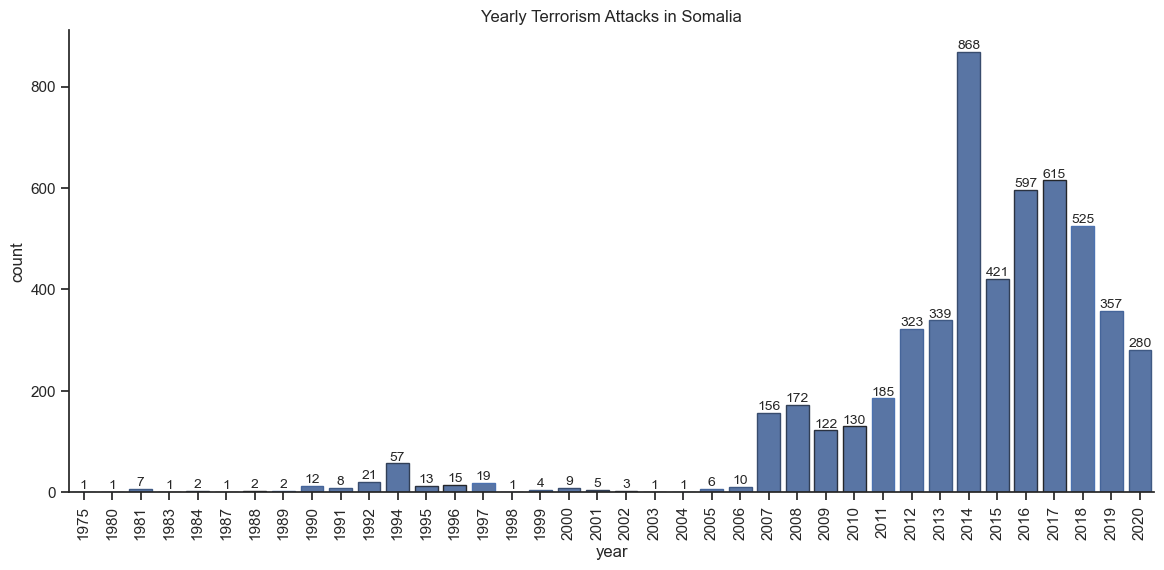

In [1535]:
sns.set_theme(style='ticks')
palette = 'dark:b_r'
# Count occurrences for each year
year_counts = df['year'].value_counts().sort_index()

# Create a figure for the countplot
plt.subplots(figsize=(14, 6))

# Create the countplot using the balanced color palette
ax = sns.countplot(data=df, x='year', edgecolor=sns.color_palette(palette, 7))

# Rotate x-ticks for better readability
plt.xticks(rotation=90)

# Set the title of the plot
plt.title('Yearly Terrorism Attacks in Somalia')

# Add the number of incidents on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Positioning the label
                ha='center', va='bottom', fontsize=10)

sns.despine()
# Show the plot
plt.show()

- ### **Which years experienced significant spikes or declines in attacks?**  

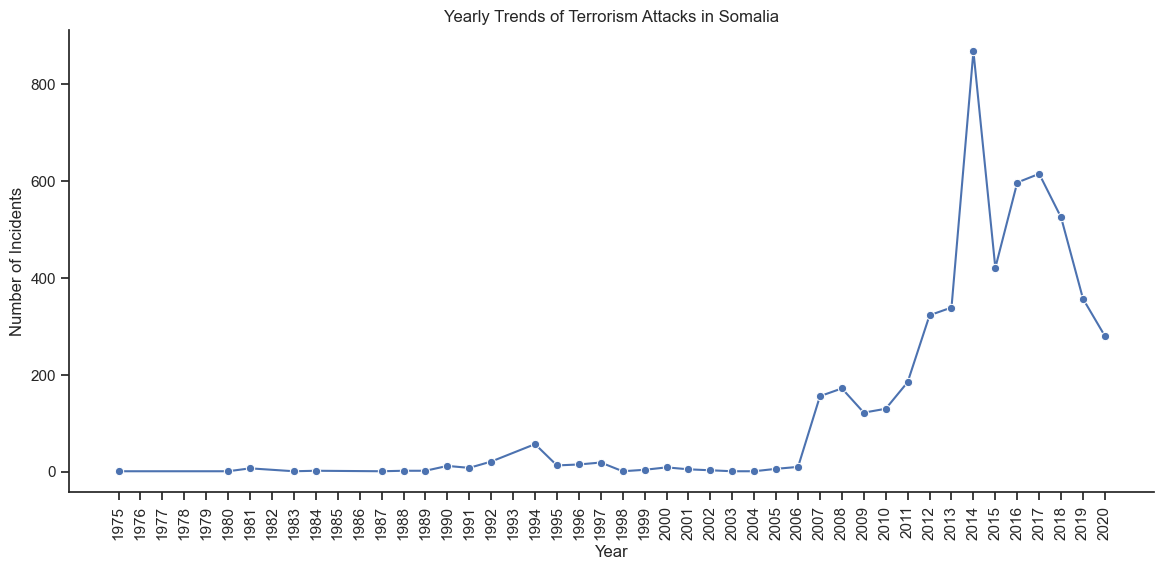

In [1536]:
# Group by year and count incidents
annual_counts = df.groupby('year').size()
all_years = range(df['year'].min(), df['year'].max() + 1)

# Set the Seaborn theme to 'ticks'
sns.set_theme(style='ticks')

# Create the line plot
plt.figure(figsize=(14, 6))
sns.lineplot(x=annual_counts.index, y=annual_counts.values, 
             marker="o", color=sns.color_palette("dark:b_r")[0])  # Use the first color from the palette

# Adding title and labels
plt.title("Yearly Trends of Terrorism Attacks in Somalia")
plt.xlabel("Year")

plt.ylabel("Number of Incidents")
plt.xticks(all_years)
plt.xticks(rotation=90)
sns.despine()
plt.show()

- ### **Which months see the highest terrorism attacks?**  

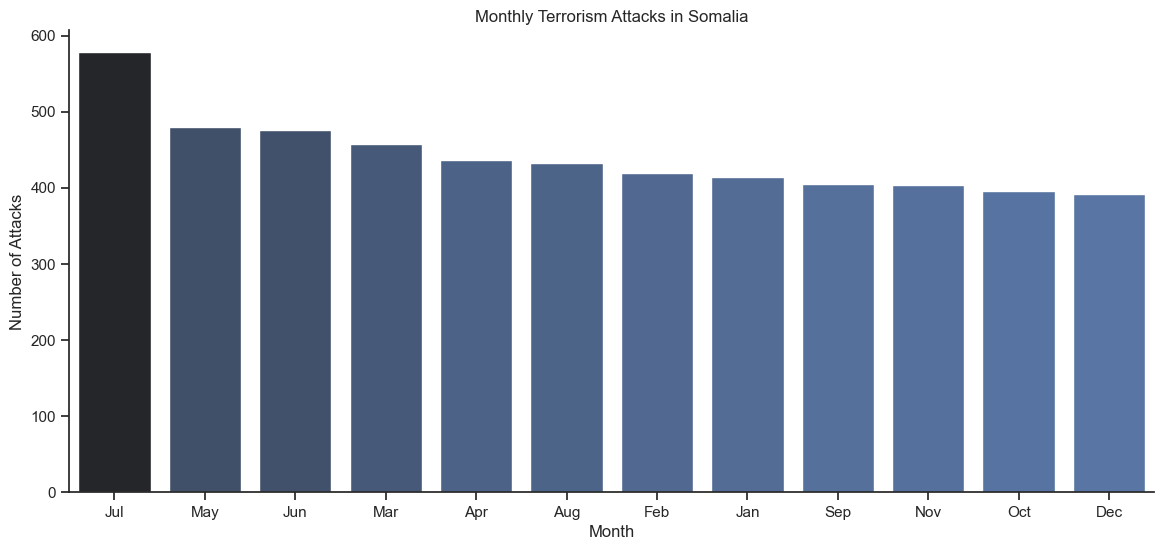

In [1537]:
sns.set_theme(style='ticks')
palette = 'dark:b_r'
# 2. Attack count by month (Bar Chart)
attacks_per_month = df.groupby('month_name').size().reset_index(name='attack_count')
attacks_per_month = attacks_per_month.sort_values(by='attack_count', ascending=False)
plt.figure(figsize=(14, 6))
sns.barplot(x='month_name', y='attack_count', hue='attack_count', legend=False, data=attacks_per_month, palette=palette)
plt.title('Monthly Terrorism Attacks in Somalia')
plt.xlabel('Month')
plt.ylabel('Number of Attacks')
sns.despine()
plt.show()

- ### **Are certain days of the month associated with higher attack frequencies?**  

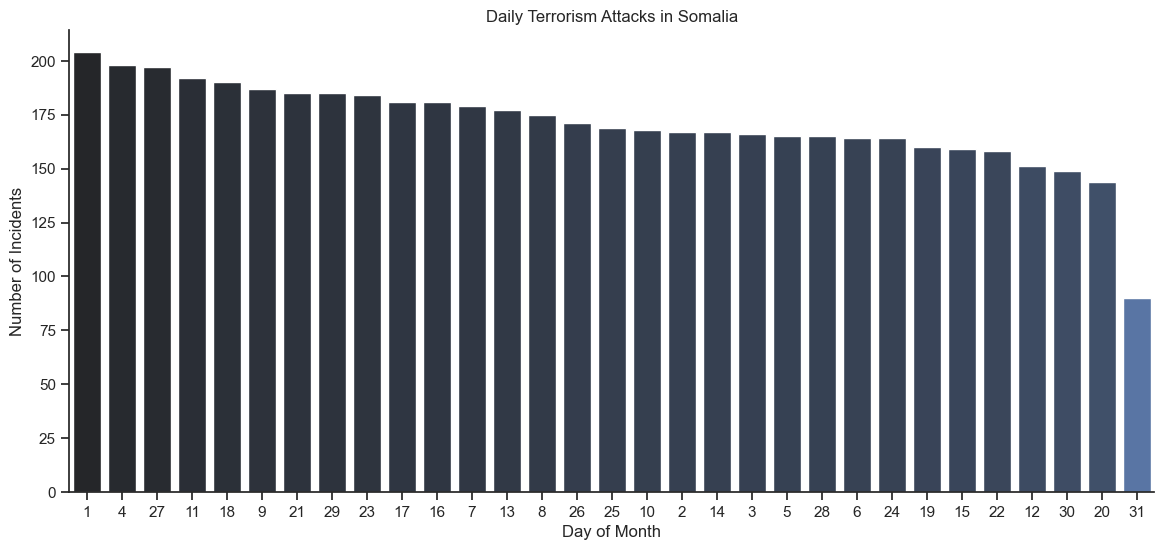

In [1538]:
# Set the Seaborn theme and palette
sns.set_theme(style='ticks')
palette = 'dark:b_r'

# Create a new DataFrame with counts of incidents for each day
day_counts = df['day'].value_counts().reset_index()
day_counts.columns = ['day', 'incident_count']

# Sort the counts in descending order based on the incident count
day_counts = day_counts.sort_values(by='incident_count', ascending=False)

# Set the order of days based on the sorted values
day_order = day_counts['day']

# Plot: Days of the month showing higher attack frequencies
plt.figure(figsize=(14, 6))
sns.barplot(data=day_counts, x='day', y='incident_count', hue='incident_count', legend=False, palette=palette, order=day_order)
plt.title("Daily Terrorism Attacks in Somalia")
plt.xlabel("Day of Month")
plt.ylabel("Number of Incidents")
plt.xticks(rotation=0)  # Rotate x-ticks if needed
sns.despine()
plt.show()

- ### **How do attacks vary by day of the week?**  

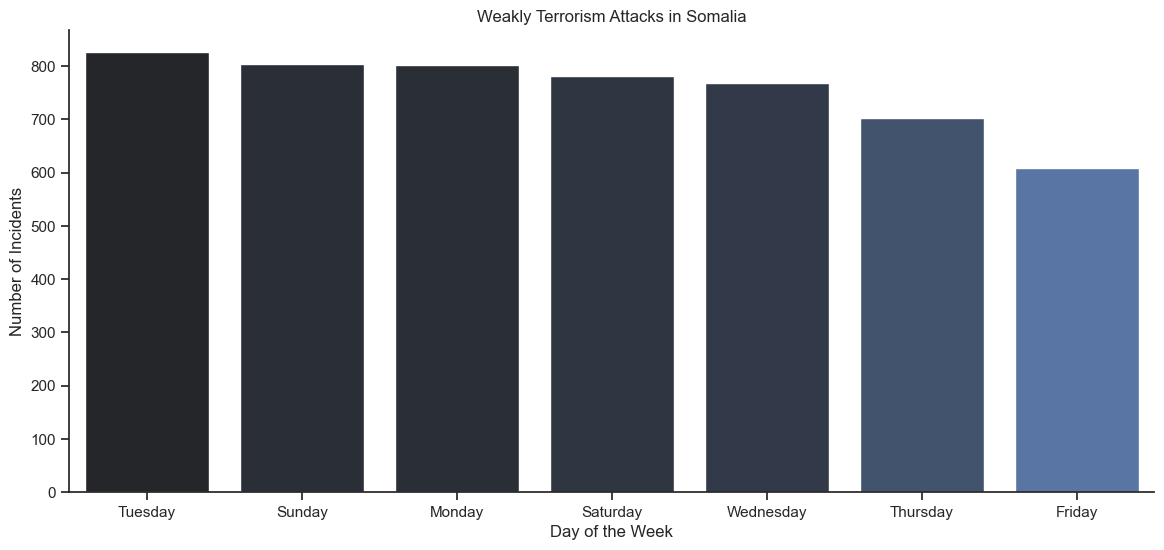

In [1539]:
# Set the Seaborn theme and palette
sns.set_theme(style='ticks')
palette = 'dark:b_r'

# Create a new DataFrame with counts of incidents for each day of the week
day_of_week_counts = df['day_of_week'].value_counts().reset_index()
day_of_week_counts.columns = ['day_of_week', 'incident_count']

# Sort the counts in descending order based on the incident count
day_of_week_counts = day_of_week_counts.sort_values(by='incident_count', ascending=False)

# Set the order of days of the week based on the sorted values
day_order = day_of_week_counts['day_of_week']

# Plot: Days of the week showing higher attack frequencies
plt.figure(figsize=(14, 6))
sns.barplot(data=day_of_week_counts, x='day_of_week', y='incident_count', hue='incident_count', legend=False, palette=palette, order=day_order)
plt.title("Weakly Terrorism Attacks in Somalia")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Incidents")
plt.xticks(rotation=0)  # Rotate x-ticks if needed
sns.despine()
plt.show()

- ### **Do casualties increase over time?** 

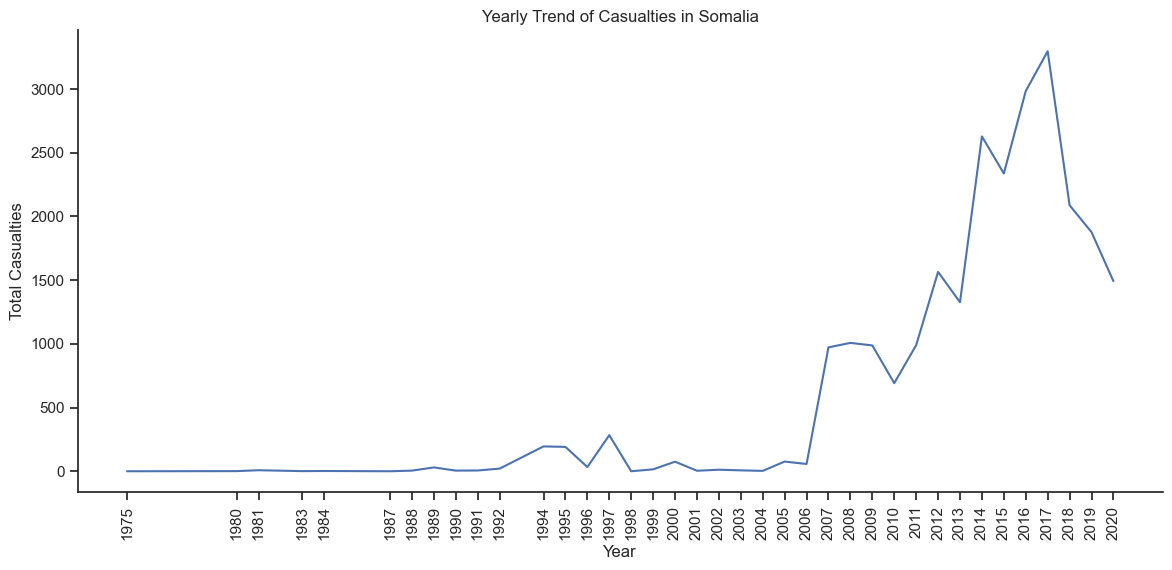

In [1540]:
# Group by year and sum casualties
annual_casualties = df.groupby('year')['total_casualties'].sum()

# Visualization
plt.figure(figsize=(14, 6))
sns.lineplot(x=annual_casualties.index, y=annual_casualties.values)
plt.title('Yearly Trend of Casualties in Somalia')
plt.xlabel('Year')
plt.ylabel('Total Casualties')
plt.xticks(annual_casualties.index)
plt.xticks(rotation=90)
sns.despine()
plt.show()

- #### **Are suicide attacks more frequent in certain months?** 

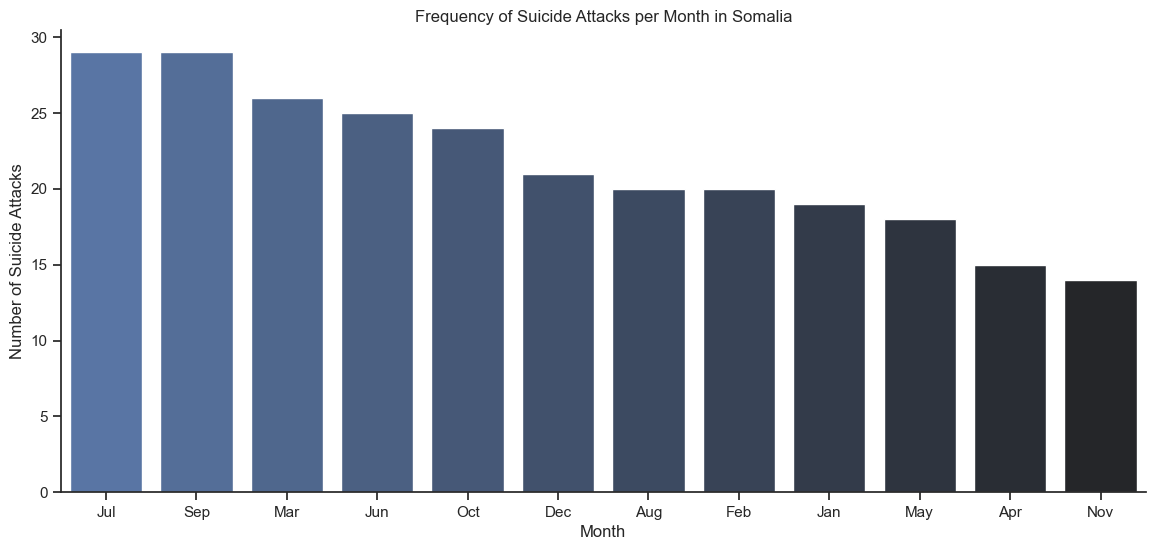

In [1541]:
# Set the Seaborn theme and palette
sns.set_theme(style='ticks')
palette = 'dark:b_r'
# Count suicide attacks per month
monthly_suicide_attacks = df[df['suicide'] == 1]['month_name'].value_counts().sort_index()
monthly_suicide_attacks = monthly_suicide_attacks.sort_values(ascending=False)
# Visualization
plt.figure(figsize=(14, 6))
sns.barplot(x=monthly_suicide_attacks.index, y=monthly_suicide_attacks.values, palette=palette)
plt.title('Frequency of Suicide Attacks per Month in Somalia')
plt.xlabel('Month')
plt.ylabel('Number of Suicide Attacks')
plt.xticks(monthly_suicide_attacks.index)
sns.despine()
plt.show()

## **2. Geospatial Analysis**

- ### **Which Regions & Cities have the most Terrorism attacks?**  

In [1542]:
region_city_attack_counts = df.groupby(['region', 'city']).size().reset_index(name='attack_count')
region_city_attack_counts = region_city_attack_counts.sort_values(by='attack_count', ascending=False).head(10)
region_city_attack_counts

,region,city,attack_count
38,Banaadir,Mogadishu,1986
174,Jubbada Hoose,Kismaayo,236
3,Baay,Baydhaba,195
258,Shabeellaha Hoose,Afgooye,171
104,Hiiraan,Beledweyne,171
201,Mudug,Gaalkacyo,132
43,Bari,Boosaaso,129
299,Shabeellaha Hoose,Marka,115
303,Shabeellaha Hoose,Qoryooleey,110
88,Gedo,Baardheere,70


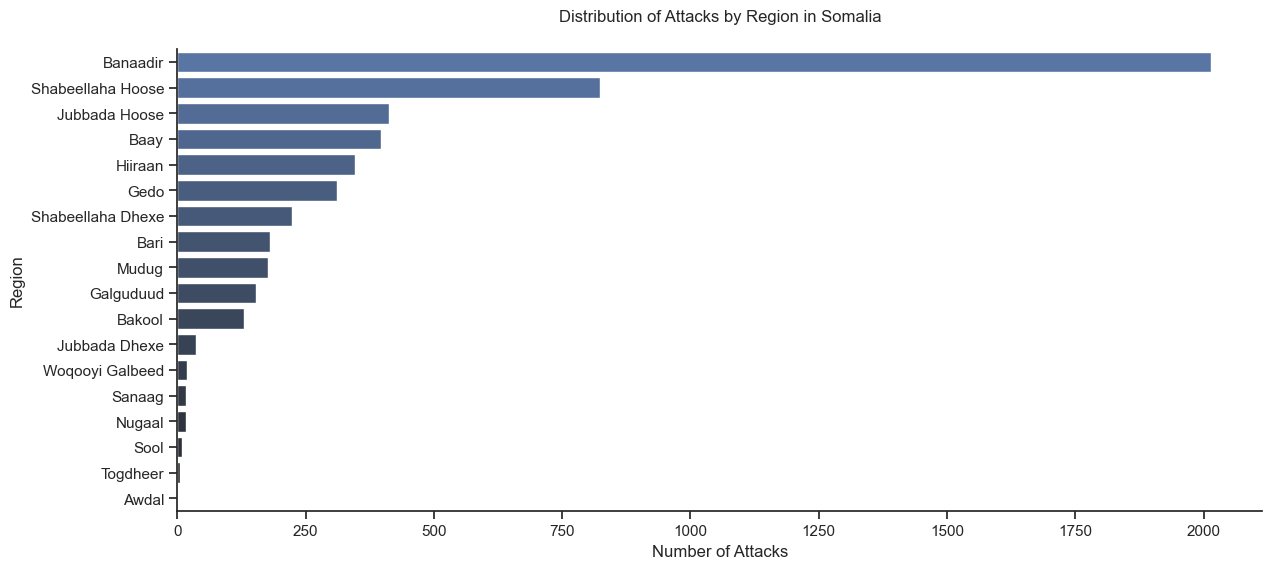

In [1543]:
# Set the Seaborn theme and palette
sns.set_theme(style='ticks')
palette = 'dark:b_r'

df_reg = df[df['region']!= 'Unknown']
# Count attacks by region
region_attacks = df_reg['region'].value_counts().reset_index()
region_attacks.columns = ['region', 'attack_count']
region_attacks.sort_values(by='attack_count', ascending=False, inplace=True)

# Visualization
plt.figure(figsize=(14, 6))

# Create the bar plot for attack counts by region
sns.barplot(x='attack_count', y='region', data=region_attacks, palette=palette)

# Set plot title and labels
plt.title('Distribution of Attacks by Region in Somalia', pad=20)
plt.xlabel('Number of Attacks')
plt.ylabel('Region')
plt.xticks(rotation=0)
sns.despine()
# Show the plot
plt.show()

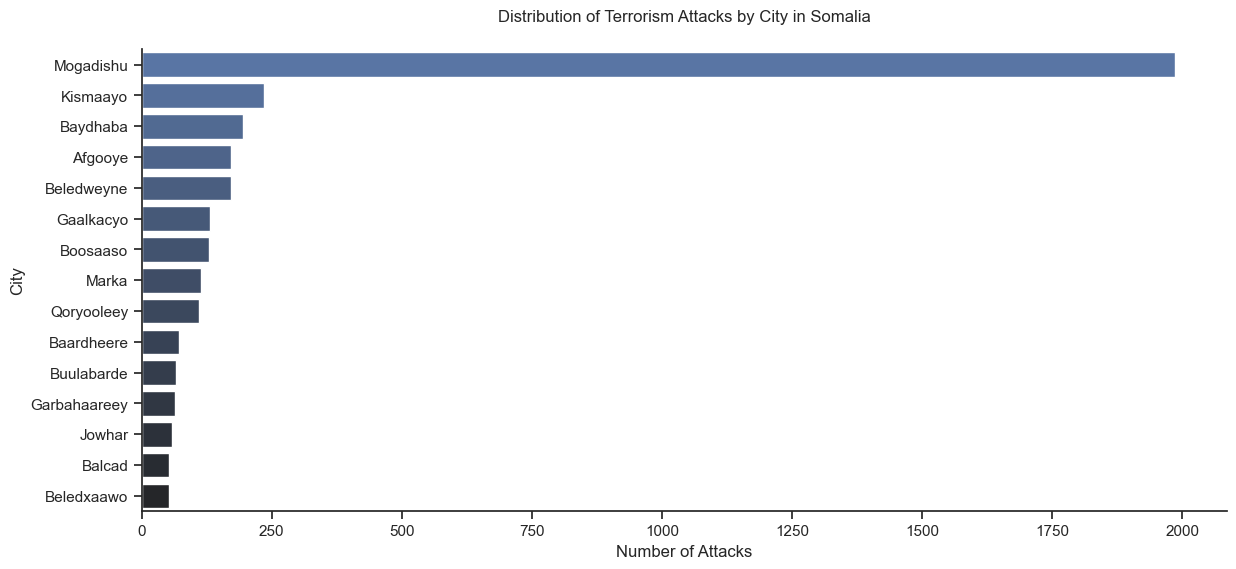

In [1544]:
# Set the Seaborn theme and palette
sns.set_theme(style='ticks')
palette = 'dark:b_r'
df_cit = df[df['city']!= 'Unknown']
# Count attacks by city
city_attacks = df_cit['city'].value_counts().reset_index()
city_attacks.columns = ['city', 'attack_count']
city_attacks.sort_values(by='attack_count', ascending=False, inplace=True)

# Filter for the top 20 cities
top_20_cities = city_attacks.head(15)

# Visualization
plt.figure(figsize=(14, 6))

# Create the bar plot for attack counts by top 15 cities
sns.barplot(x='attack_count', y='city', data=top_20_cities, palette=palette)

# Set plot title and labels
plt.title('Distribution of Terrorism Attacks by City in Somalia', pad=20)
plt.xlabel('Number of Attacks')
plt.ylabel('City')
plt.xticks(rotation=0)
sns.despine()
# Show the plot
plt.show()


- ### **What cities are the primary hotspots for terrorist Attacks?**  

In [1545]:
# Group by city and count the number of attacks
city_attack_counts = df['city'].value_counts().reset_index(name='attack_count')
city_attack_counts.columns = ['City', 'Number of Attacks']
city_attack_counts = city_attack_counts.sort_values(by='Number of Attacks', ascending=False)
top_hotspots = city_attack_counts.head(10)
top_hotspots

,City,Number of Attacks
0,Mogadishu,1986
1,Kismaayo,236
2,Baydhaba,195
3,Afgooye,171
4,Beledweyne,171
5,Gaalkacyo,132
6,Boosaaso,129
7,Marka,115
8,Qoryooleey,110
9,Baardheere,71


- ### **What are Percentage of Terrorism Attacks by Region and city**

In [1546]:
# Group by region and city and count the number of attacks
region_city_attack_percent = df.groupby(['region', 'city']).size().reset_index(name='attack_count')
total_attacks = region_city_attack_percent['attack_count'].sum()
region_city_attack_percent['attack_percentage'] = (region_city_attack_percent['attack_count'] / total_attacks) * 100
region_city_attack_percent = region_city_attack_percent.sort_values(by='attack_percentage', ascending=False)
region_city_attack_percent['attack_percentage'] = region_city_attack_percent['attack_percentage'].round(0).astype(int).astype(str) + '%'
region_city_attack_percent = region_city_attack_percent[['region', 'city', 'attack_percentage']]
region_city_attack_percent.head(10)

,region,city,attack_percentage
38,Banaadir,Mogadishu,38%
174,Jubbada Hoose,Kismaayo,4%
3,Baay,Baydhaba,4%
258,Shabeellaha Hoose,Afgooye,3%
104,Hiiraan,Beledweyne,3%
201,Mudug,Gaalkacyo,2%
43,Bari,Boosaaso,2%
299,Shabeellaha Hoose,Marka,2%
303,Shabeellaha Hoose,Qoryooleey,2%
88,Gedo,Baardheere,1%


- ### **What regions and cities have the highest success rates for terrorist attacks?**

In [1547]:
# Grouping by both region and city
df_region_city = pd.DataFrame(df[df['success'] == 1].groupby(['region', 'city']).size(), columns=['Successful'])
df_region_city['Not_Successful'] = df[df['success'] == 0].groupby(['region', 'city']).size()
df_region_city.fillna(0, inplace=True)
df_region_city['Total'] = df_region_city['Successful'] + df_region_city['Not_Successful']
df_region_city['Success_Rate'] = (df_region_city['Successful'] / df_region_city['Total']) * 100

df_region_city.sort_values(by='Total', ascending=False, inplace=True)
top_10_region_city = df_region_city.head(10)
top_10_region_city_final = top_10_region_city.reset_index()[['region', 'city', 'Success_Rate']]
top_10_region_city_final['Success_Rate'] = top_10_region_city_final['Success_Rate'].round(0).astype(int).astype(str) + '%'

# Convert Success_Rate back to numerical form for sorting
top_10_region_city_final['Success_Rate_numeric'] = top_10_region_city_final['Success_Rate'].str.rstrip('%').astype(int)
top_10_region_city_final_sorted = top_10_region_city_final.sort_values(by='Success_Rate_numeric', ascending=False)
top_10_region_city_final_sorted = top_10_region_city_final_sorted.drop(columns=['Success_Rate_numeric']).reset_index(drop=True)
top_10_region_city_final_sorted

,region,city,Success_Rate
0,Baay,Baydhaba,94%
1,Hiiraan,Beledweyne,94%
2,Jubbada Hoose,Kismaayo,92%
3,Shabeellaha Hoose,Afgooye,92%
4,Shabeellaha Hoose,Marka,92%
5,Banaadir,Mogadishu,91%
6,Mudug,Gaalkacyo,88%
7,Gedo,Baardheere,87%
8,Bari,Boosaaso,85%
9,Shabeellaha Hoose,Qoryooleey,84%


- ### **What percentage of attacks occur in coastal, border, and other Cities?**

In [1548]:
# Define the categories for coastal and border cities
# Define coastal and border cities
coastal_cities = ['Mogadishu', 'Kismayo',  'Hobyo', 'Qandala', 'Baraawe', 'Maydh', 'Baargaal', 
                  'Jamaame', 'Goobweyn', 'Jaziira', 'Gandarshe', 'Warsheikh', 'Cadale', 'Buurgaabo',
                  'Marka', 'Laas Qoray', 'Boosaaso', 'Eyl', 'Xarardheere', 'kambooni']

border_cities = ['Buulaxaawo', 'Baardheere', 'Ceel Waaq', 'Doolow', 'Luuq', 'Beledxaawo',
                 'Garbahaareey', 'Beledweyne', 'Dhoobleey', 'Caabud Waaq', 'Galdogob',
                 'Feer feer', 'Ceelbarde', 'Yeed', 'Diff', ''
                 ]

df['city_category'] = df['city'].apply(lambda x: 'Coastal' if x in coastal_cities else 
                                         ('Border' if x in border_cities else 'Other'))
city_category_counts = df['city_category'].value_counts().reset_index(name='attack_count')
city_category_counts.columns = ['City Category', 'Number of Attacks']
total_attacks = city_category_counts['Number of Attacks'].sum()
city_category_counts['Percentage of Attacks (%)'] = (city_category_counts['Number of Attacks'] / total_attacks) * 100
city_category_counts['Percentage of Attacks (%)'] = city_category_counts['Percentage of Attacks (%)'].round(0).astype(int).astype(str) + '%'
city_category_counts

,City Category,Number of Attacks,Percentage of Attacks (%)
0,Other,2521,48%
1,Coastal,2317,44%
2,Border,454,9%


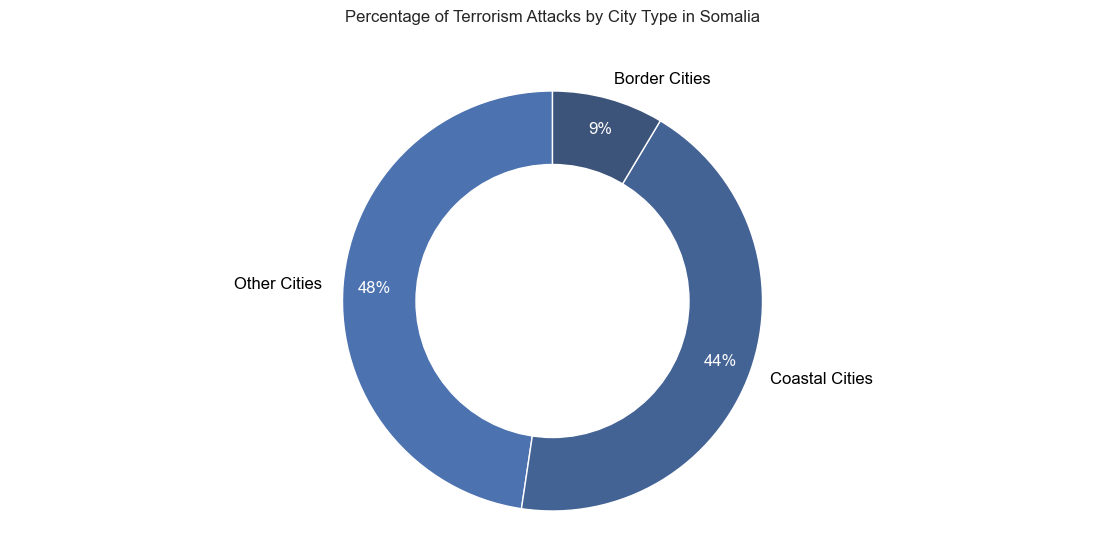

In [1549]:
# Set the Seaborn theme and color palette
sns.set_theme(style='ticks')
palette = sns.color_palette('dark:b_r')

plt.figure(figsize=(14, 6))
wedges, texts, autotexts = plt.pie(city_counts['percentage'], labels=city_counts['city_type'],
                                  colors=palette, autopct=pct_color_white, startangle=90, pctdistance=0.85)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)
for text in texts:
    text.set_color('black')
    text.set_fontsize(12)
centre_circle = plt.Circle((0, 0), 0.65, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.title('Percentage of Terrorism Attacks by City Type in Somalia', pad=35)
sns.despine()
plt.show()

- #### **What are the most common attack types in Somalia?**  

In [1550]:
# Group by attack type and count the number of occurrences
attack_type_counts = df.groupby('attack_type').size().reset_index(name='attack_count')
attack_type_counts = attack_type_counts.sort_values(by='attack_count', ascending=False)
attack_type_counts

,attack_type,attack_count
2,Bombing/Explosion,2136
0,Armed Assault,1480
1,Assassination,642
9,Unknown,471
6,Hostage Taking (Kidnapping),425
3,Facility/Infrastructure Attack,74
4,Hijacking,38
5,Hostage Taking (Barricade Incident),16
8,Unarmed Assault,9
7,Military,1


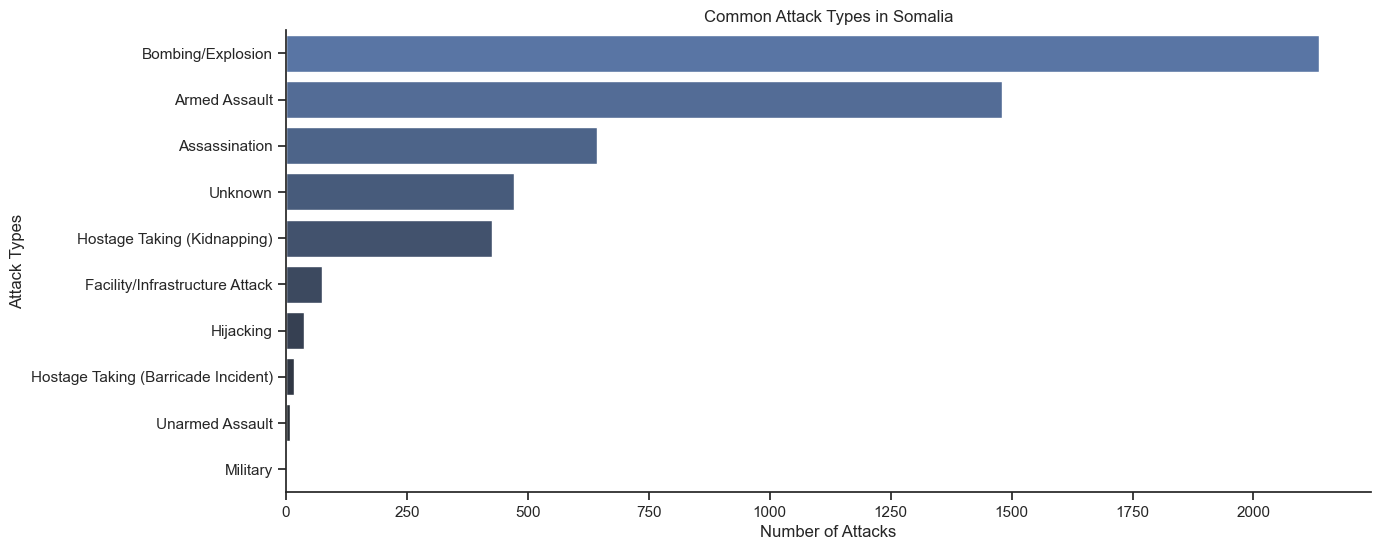

In [1551]:
sns.set_theme(style='ticks')
palette = 'dark:b_r'

attack_types = df['attack_type'].value_counts().reset_index()
attack_types.columns = ['attack_type', 'attack_count']
attack_types = attack_types.head(10)

plt.figure(figsize=(14, 6))
sns.barplot(x='attack_count', y='attack_type', data=attack_types, palette= palette)
plt.title('Common Attack Types in Somalia')
plt.xlabel('Number of Attacks')
plt.ylabel('Attack Types')
sns.despine()
plt.show()

- ### **What percentage of attacks use explosives?**  

In [1552]:
# Count the total number of attacks
total_attacks = df.shape[0]
explosive_attacks = df[df['weapon_type'].str.contains('explosive', case=False)].shape[0]
percentage_explosive_attacks = (explosive_attacks / total_attacks) * 100
print(f"Percentage of attacks that use explosives: {percentage_explosive_attacks:.0f}%")

Percentage of attacks that use explosives: 49%


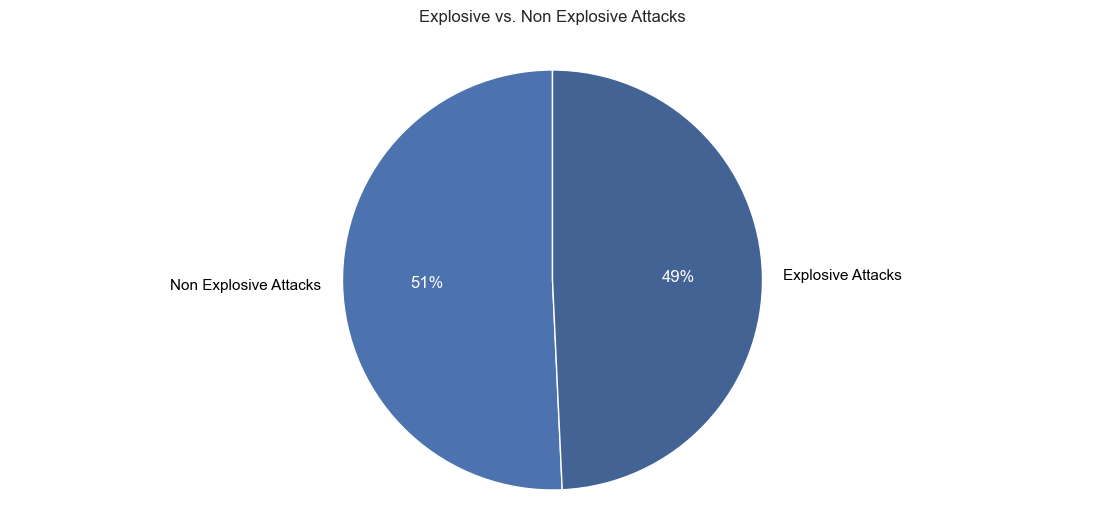

In [1553]:
# Set the Seaborn theme and palette
sns.set_theme(style='ticks')
palette = sns.color_palette('dark:b_r')

explosive_attacks = df['weapon_type'].str.contains('Explosives', case=False)
explosive_counts = explosive_attacks.value_counts()

labels = ['Non Explosive Attacks', 'Explosive Attacks']
sizes = explosive_counts.values

plt.figure(figsize=(14, 6))
wedges, texts, autotexts = plt.pie(sizes, labels=labels, autopct='%1.0f%%', startangle=90, colors=palette)
for text in texts:
    text.set_color('black') 
for autotext in autotexts:
    autotext.set_color('white') 
plt.axis('equal')
plt.title('Explosive vs. Non Explosive Attacks', pad=20)
plt.show()

- ### **What attack types have the highest casualties?**  

In [1554]:
# Sort the DataFrame by total casualties in descending order
attack_casualty_counts = attack_casualty_counts.sort_values(by='total_casualties', ascending=False)
top_attack_casualties = attack_casualty_counts[['attack_type', 'total_casualties']]
top_attack_casualties.head(10)

,attack_type,total_casualties
2,Bombing/Explosion,13650
0,Armed Assault,5787
9,Unknown,2199
1,Assassination,1643
6,Hostage Taking (Kidnapping),1314
5,Hostage Taking (Barricade Incident),454
8,Unarmed Assault,108
3,Facility/Infrastructure Attack,77
4,Hijacking,28
7,Military,1


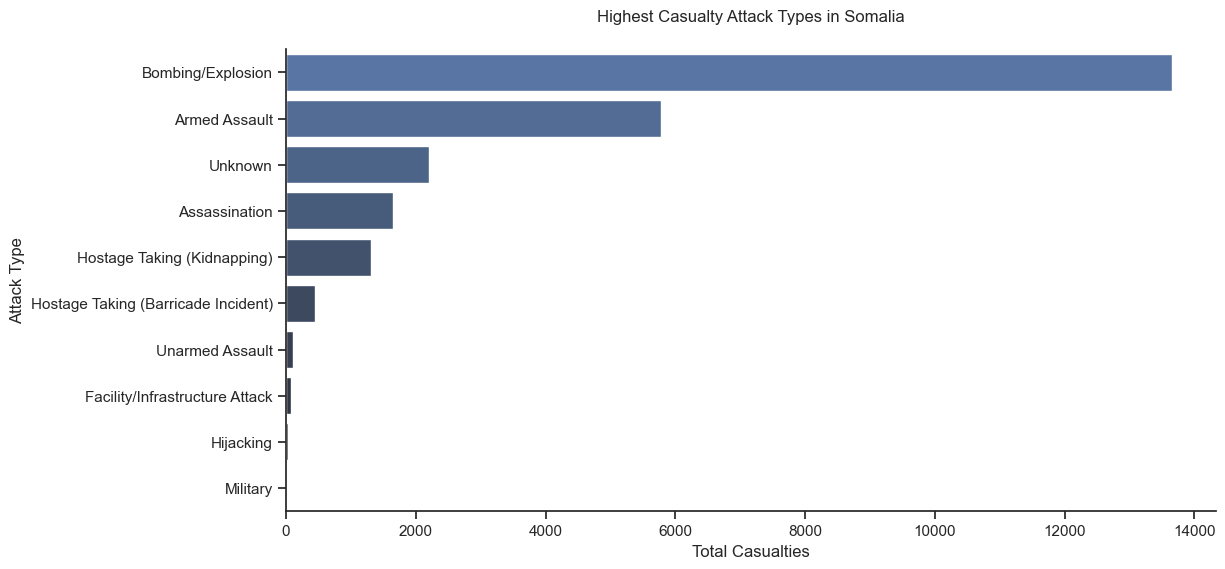

In [1555]:
sns.set_theme(style='ticks')
palette = 'dark:b_r'
# Calculate average casualties by attack type
avg_casualties_by_type = df.groupby('attack_type')['total_casualties'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=avg_casualties_by_type.values, y=avg_casualties_by_type.index,  palette=palette)
plt.title('Highest Casualty Attack Types in Somalia', pad=20)
plt.xlabel('Total Casualties')
plt.ylabel('Attack Type')
plt.xticks(rotation=0)
sns.despine()
plt.show()

- ### **Are certain attack types more successful?**  

In [1556]:
# Mark successful attacks based on casualty count
df['success'] = df['total_casualties'] > 0
df_filtered = df.loc[~df['attack_type'].isin(['Military', 'Unarmed Assault'])]

# Group by attack type and calculate success rate
attack_success_counts = df_filtered.groupby('attack_type').agg(
    total_attacks=('attack_type', 'size'),  # Count total attacks
    successful_attacks=('success', 'sum')   # Count successful attacks
).reset_index()

attack_success_counts['success_rate'] = (attack_success_counts['successful_attacks'] / attack_success_counts['total_attacks']) * 100
attack_success_counts['success_rate'] = attack_success_counts['success_rate'].round(0).astype(int).astype(str) + '%'

attack_success_counts = attack_success_counts[['attack_type', 'success_rate']].sort_values(by='success_rate', ascending=False)
attack_success_counts

,attack_type,success_rate
0,Armed Assault,94%
1,Assassination,91%
7,Unknown,87%
2,Bombing/Explosion,81%
5,Hostage Taking (Barricade Incident),75%
6,Hostage Taking (Kidnapping),68%
4,Hijacking,47%
3,Facility/Infrastructure Attack,16%


- ### **How has the Trend of suicide attacks in Somalia changed over the years?**

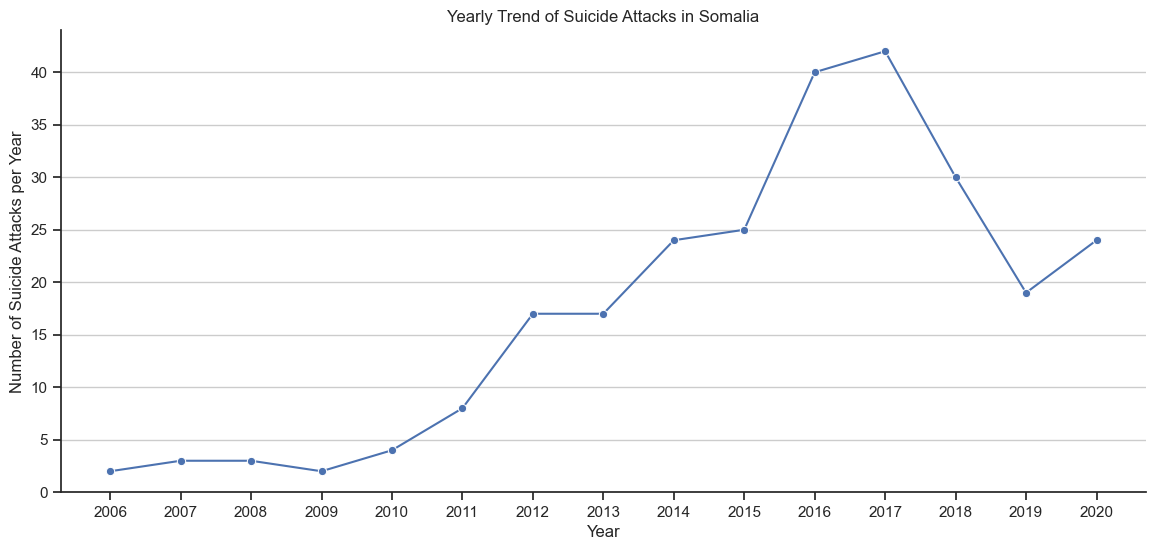

In [1557]:
sns.set_theme(style='ticks')
palette = 'dark:b_r'

# Count suicide attacks per year
suicide_attacks_per_year = df[df['suicide'] == 1].groupby('year')['eventid'].count()

plt.figure(figsize=(14, 6))
sns.lineplot(x=suicide_attacks_per_year.index, y=suicide_attacks_per_year.values, marker='o', palette=palette)
plt.title('Yearly Trend of Suicide Attacks in Somalia')
plt.xlabel('Year')
plt.ylabel('Number of Suicide Attacks per Year')
plt.xticks(suicide_attacks_per_year.index)
plt.grid(axis='y')
sns.despine()
plt.show()

- ### **Which weapon types are most common in Bombing/Explosion Attacks?**  

In [1558]:
# Filter for suicide attacks
suicide_attacks = df[df['attack_type'] == 'Bombing/Explosion']

weapon_counts = suicide_attacks['weapon_subtype'].value_counts().reset_index()
weapon_counts.columns = ['weapon_subtype', 'total_attacks']
weapon_counts.sort_values(by='total_attacks', ascending=False, inplace=True)
weapon_counts

,weapon_subtype,total_attacks
0,Unknown Explosive Type,486
1,Landmine,406
2,"Projectile (rockets, mortars, RPGs, etc.)",384
3,Grenade,315
4,Suicide Vehicle,307
5,Remote Trigger,74
6,Sticky Bomb,68
7,Suicide Vest,57
8,Other Explosive Type,29
9,Unknown Gun Type,5


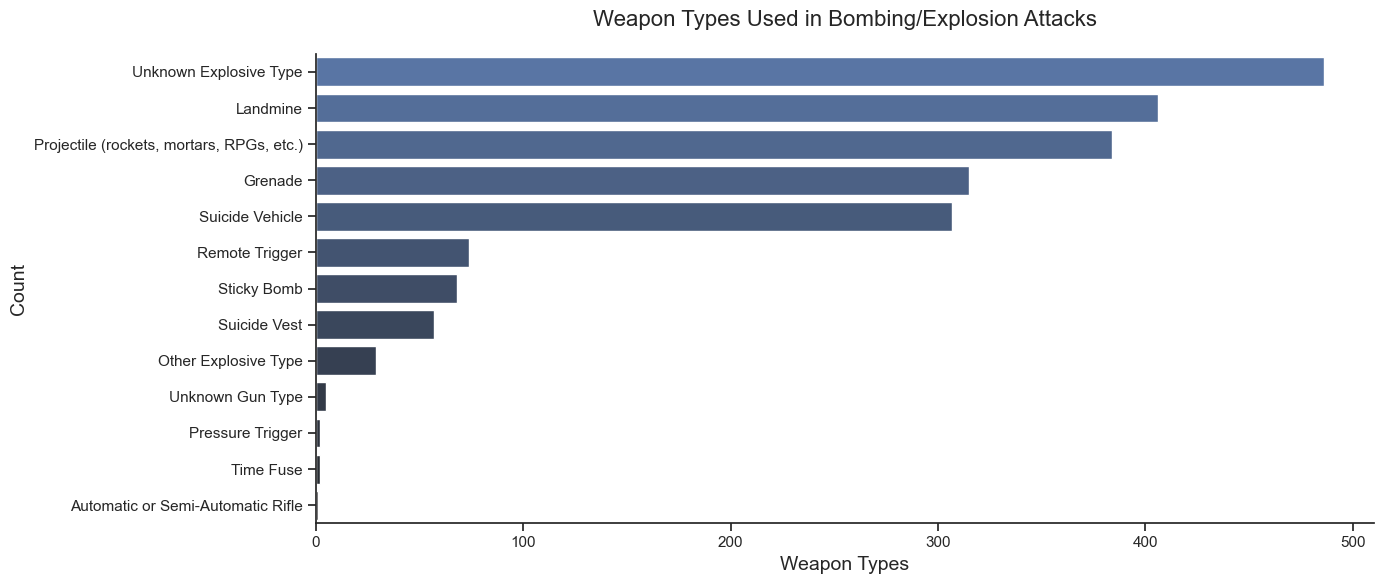

In [1559]:
plt.figure(figsize=(14, 6))
sns.barplot(x='total_attacks' , y='weapon_subtype', data=weapon_counts, palette=palette)

plt.title('Weapon Types Used in Bombing/Explosion Attacks', pad=20, fontsize=16)
plt.xlabel('Weapon Types', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
sns.despine()
plt.show()

- ### **Is there a correlation between attack types and specific regions?** 

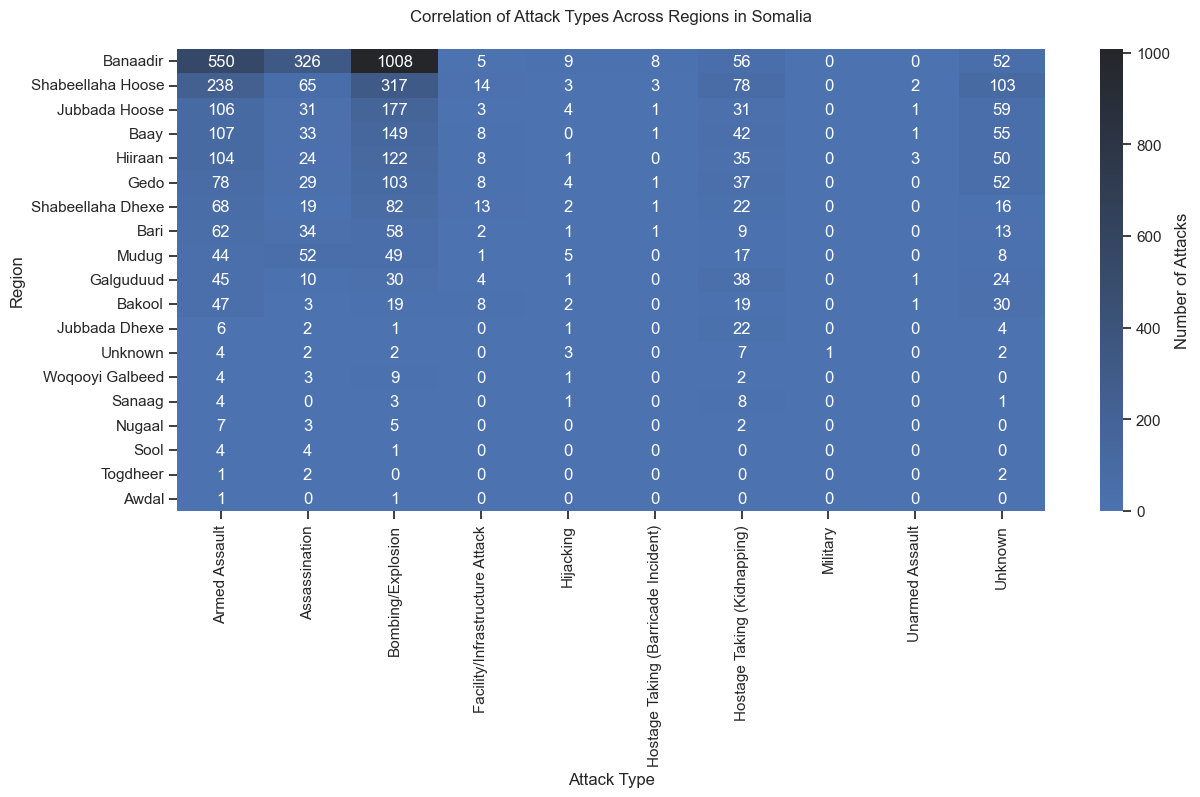

In [1560]:
# Set the Seaborn theme and color palette
sns.set_theme(style='ticks')
palette = sns.color_palette('dark:b_r', as_cmap=True)

attack_type_region = df.pivot_table(index='region', columns='attack_type', values='eventid', aggfunc='count', fill_value=0)

attack_type_region['Total'] = attack_type_region.sum(axis=1)
attack_type_region = attack_type_region.sort_values(by='Total', ascending=False).drop(columns='Total')

plt.figure(figsize=(14, 6))
sns.heatmap(attack_type_region, cmap=palette, annot=True, fmt='d', cbar_kws={'label': 'Number of Attacks'})
plt.title('Correlation of Attack Types Across Regions in Somalia', pad=20)
plt.xlabel('Attack Type')
plt.ylabel('Region')
plt.xticks(rotation=90)
plt.show()

## **4. Target Type**

- ### **What are the most frequently targeted groups in Somalia?**  

In [1561]:
# Count occurrences of each targeted group
targeted_group_counts = df['target_type'].value_counts().reset_index()
targeted_group_counts.columns = ['targeted_group', 'count']

targeted_group_counts.sort_values(by='count', ascending=False, inplace=True)
targeted_group_counts

,targeted_group,count
0,Military,2163
1,Private Citizens & Property,937
2,Government (General),869
3,Police,315
4,Business,246
5,Diplomatic,141
6,Unknown,107
7,NGO,107
8,Journalists & Media,103
9,Terrorists/Non-State Militia,68


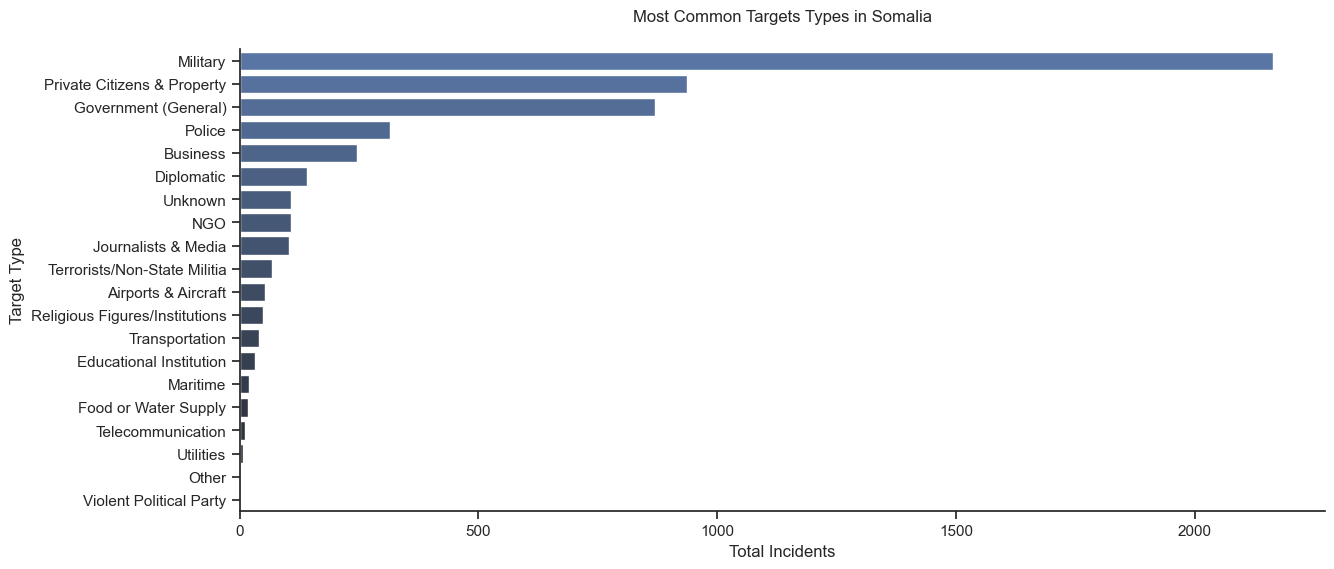

In [1562]:
sns.set_theme(style='ticks')
palette = 'dark:b_r'
# Target types
target_types = df['target_type'].value_counts().reset_index()
target_types.columns = ['target_type', 'count']

plt.figure(figsize=(14, 6))
sns.barplot(data=target_types, x='count', y='target_type', palette=palette)
plt.title('Most Common Targets Types in Somalia', pad=20)
plt.xlabel('Total Incidents')
plt.ylabel('Target Type')
sns.despine()
plt.show()

- ### **What percentage of attacks target civilians?**  

In [1563]:
# Define civilian targets
civilian_targets = ['Private Citizens & Property', 'Business', 
                    'Religious Figures/Institutions', 'Transportation',
                    'Journalists & Media', 'Food or Water Supply', 'NGO', 
                    'Educational Institution']

total_attacks = len(df)

civilian_attacks = len(df[df['target_type'].isin(civilian_targets)])
percentage_civilians = (civilian_attacks / total_attacks) * 100
percentage_civilians_str = f"{percentage_civilians:.0f}%"
print(f"Percentage of attacks targeting civilians is: {percentage_civilians_str}")

Percentage of attacks targeting civilians is: 29%


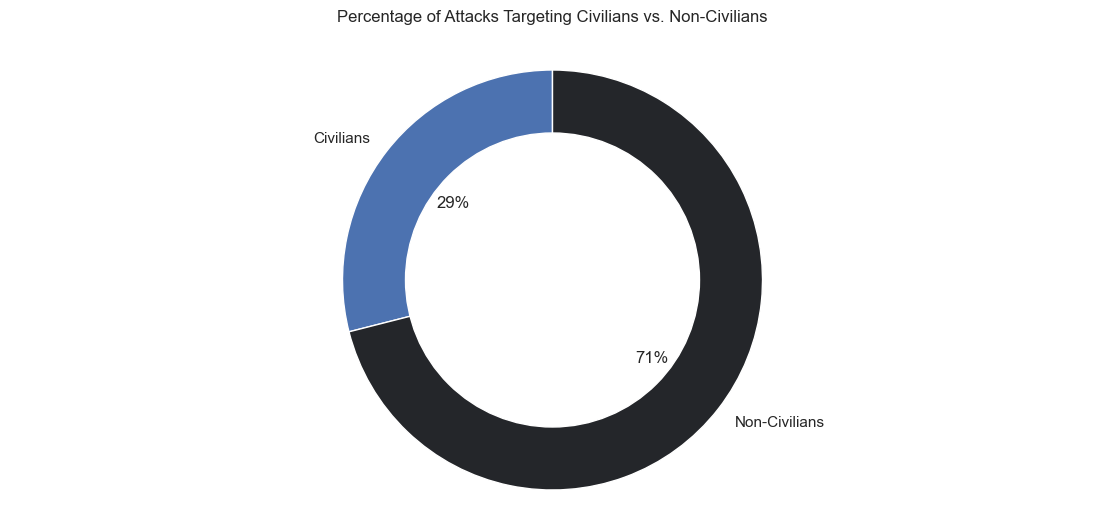

In [1564]:
# Count occurrences of each target type
target_counts = df['target_type'].value_counts()

civilian_count = target_counts[target_counts.index.isin(civilian_targets)].sum()
non_civilian_count = target_counts.sum() - civilian_count

counts = pd.Series({'Civilians': civilian_count, 'Non-Civilians': non_civilian_count})

sns.set_theme(style='ticks')
palette = 'dark:b_r' 

plt.figure(figsize=(14, 6)) 
plt.pie(counts, labels=counts.index, autopct='%1.0f%%', startangle=90, 
        colors=sns.color_palette(palette, len(counts)))

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Percentage of Attacks Targeting Civilians vs. Non-Civilians', pad=20)
plt.axis('equal')
plt.show()

- ### **Which target types see the most casualties?** 

In [1565]:
# Group by target type and sum the total casualties
casualty_counts = df.groupby('target_type')['total_casualties'].sum().reset_index()
casualty_counts['total_casualties'] = casualty_counts['total_casualties'].astype(int)

total_casualties_sum = casualty_counts['total_casualties'].sum()
casualty_counts['percentage'] = (casualty_counts['total_casualties'] / total_casualties_sum) * 100
casualty_counts['percentage'] = casualty_counts['percentage'].round(0).astype(int).astype(str) + '%'

casualty_counts = casualty_counts.sort_values(by='total_casualties', ascending=False)
casualty_counts_final = casualty_counts[['target_type', 'percentage']].head(10)
casualty_counts_final

,target_type,percentage
8,Military,40%
12,Private Citizens & Property,17%
5,Government (General),14%
1,Business,13%
11,Police,5%
15,Terrorists/Non-State Militia,3%
2,Diplomatic,2%
16,Transportation,1%
13,Religious Figures/Institutions,1%
0,Airports & Aircraft,1%


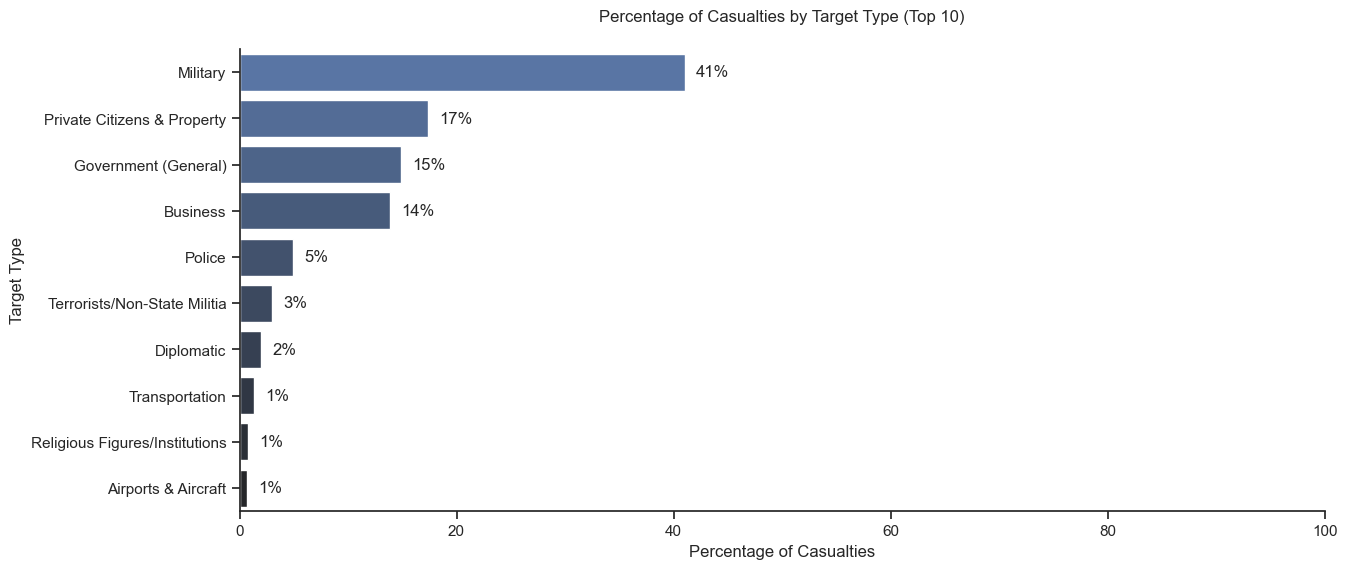

In [1566]:
# Ensure the top 10 target types are selected
top_10_target_types = casualty_counts.head(10)

top_10_target_types['percentage'] = (top_10_target_types['total_casualties'] / top_10_target_types['total_casualties'].sum()) * 100

# Set the Seaborn theme
sns.set_theme(style='ticks')

plt.figure(figsize=(14, 6)) 
bars = sns.barplot(data=top_10_target_types, y='target_type', x='percentage', palette='dark:b_r', orient='h')

plt.title('Percentage of Casualties by Target Type (Top 10)', pad=20)
plt.xlabel('Percentage of Casualties')
plt.ylabel('Target Type')
plt.xlim(0, 100) 
sns.despine()
for bar in bars.patches:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height() / 2, f'{width:.0f}%', ha='left', va='center')
plt.show()


- ### **What are the most frequently targets?**  

In [1567]:
# Count occurrences of each target type
target_counts = df['target'].value_counts().reset_index()
target_counts.columns = ['target', 'count']

target_counts.sort_values(by='count', ascending=False, inplace=True)
top_target_counts = target_counts.head(10)
top_target_counts

,target,count
0,Civilians,418
1,Somali National Army (SNA) Base,356
2,Somali National Army (SNA) Soldiers,327
3,AMISOM Convoy,286
4,AMISOM Base,261
5,AMISOM Soldiers,120
6,Somali National Army (SNA) Convoy,111
7,Unknown,110
8,Journalists,103
9,Somali National Army (SNA) Vehicles,100


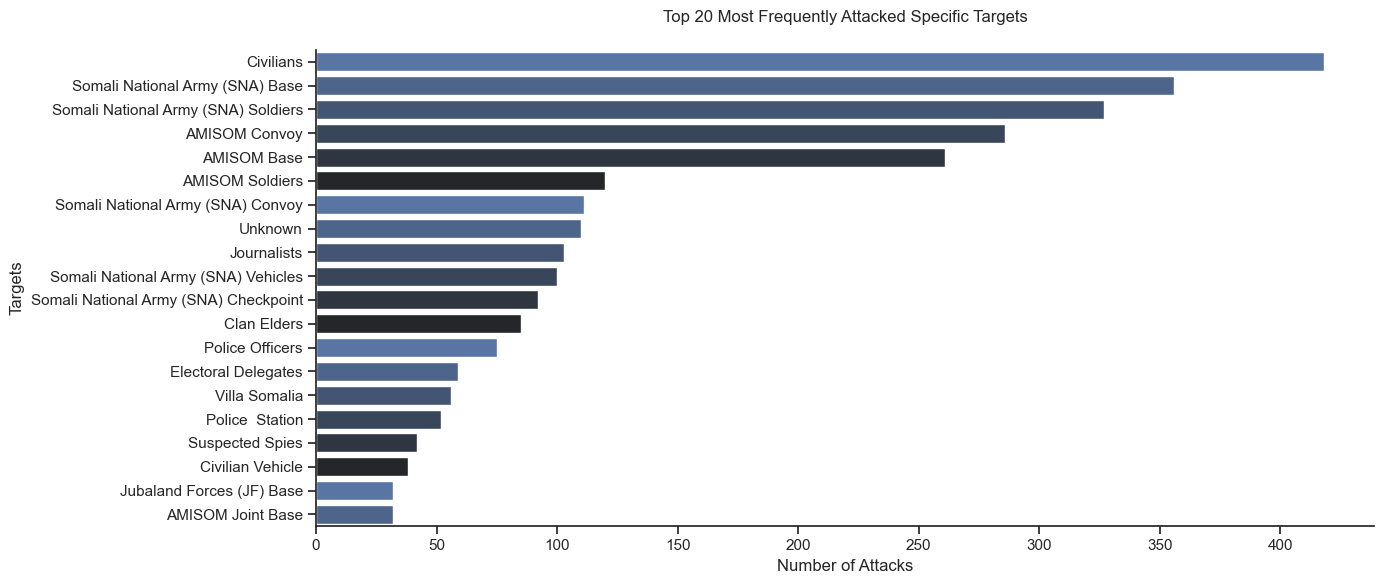

In [1568]:
# Set the Seaborn theme and color palette
sns.set_theme(style='ticks')
palette = sns.color_palette('dark:b_r')

specific_target_counts = df['target'].value_counts().head(20)

top_20_targets = specific_target_counts

plt.figure(figsize=(14, 6))
sns.barplot(x=top_20_targets.values, y=top_20_targets.index, palette=palette)
plt.title('Top 20 Most Frequently Attacked Specific Targets', pad=20)
plt.xlabel('Number of Attacks')
plt.ylabel('Targets')
plt.xticks(rotation=0)
plt.tight_layout()
sns.despine()
plt.show()

## **5. Group Analysis**

- ### **Which terrorist groups are most active in Somalia?** 

In [1569]:
# Count occurrences of each terrorist group
group_counts = df['group_name'].value_counts().reset_index()
group_counts.columns = ['terrorist_group', 'count']

total_attacks = group_counts['count'].sum()
group_counts['attack_percentage'] = (group_counts['count'] / total_attacks * 100).round(0).astype(int).astype(str) + '%'

top_groups = group_counts.head(3)
top_groups_final = top_groups[['terrorist_group', 'attack_percentage']]
top_groups_final

,terrorist_group,attack_percentage
0,Al Shabaab,73%
1,Unknown,24%
2,Daacish,1%


- ### **How has the influence of groups like Al-Shabaab evolved?**  

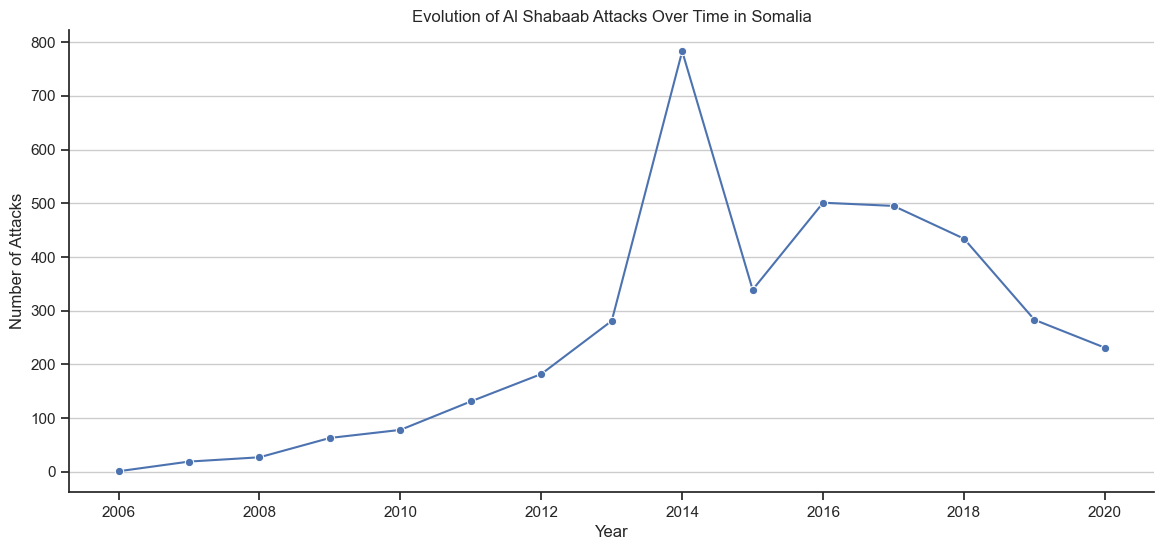

In [1570]:
sns.set_theme(style='ticks')
palette = 'dark:b_r'

al_shabaab_attacks = df[df['group_name'] == 'Al Shabaab']
al_shabaab_by_year = al_shabaab_attacks['year'].value_counts().sort_index()

plt.figure(figsize=(14, 6))
sns.lineplot(x=al_shabaab_by_year.index, y=al_shabaab_by_year.values, marker='o', palette=palette)
plt.title('Evolution of Al Shabaab Attacks Over Time in Somalia')
plt.xlabel('Year')
plt.ylabel('Number of Attacks')
plt.xticks(rotation=0)
plt.grid(axis='y') 
sns.despine()
plt.show()

- ### **What are the most common attack types used by the top Terrorist Groups in Somalia?**

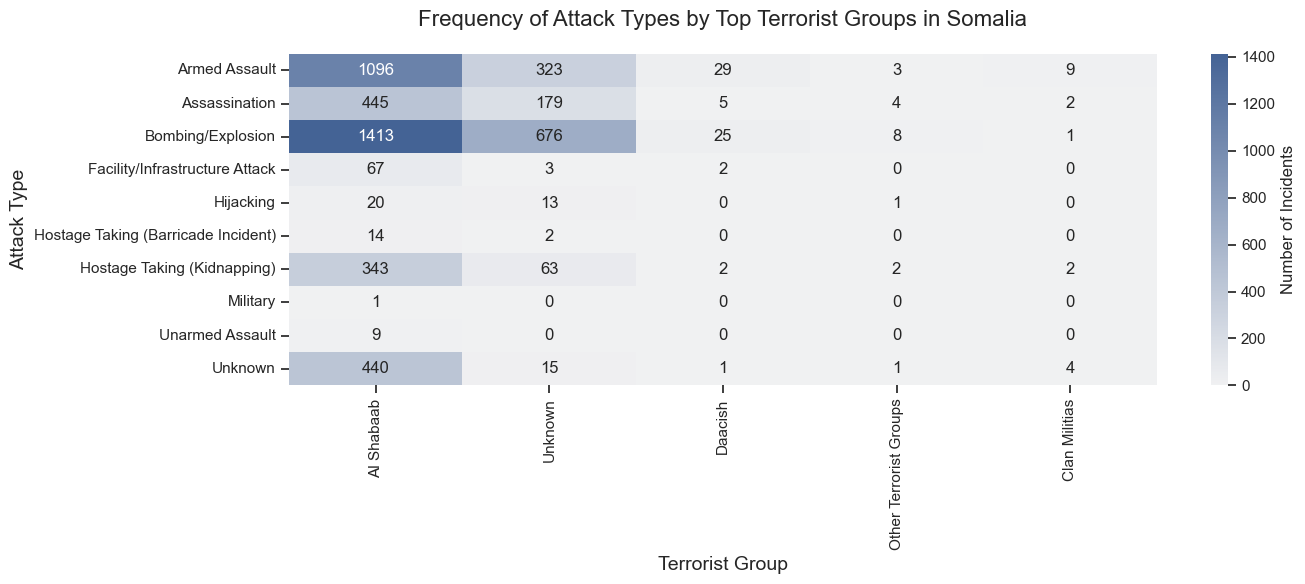

In [1571]:
# Set the Seaborn theme and color palette
sns.set_theme(style='ticks')
palette = sns.color_palette('dark:b_r')

attack_type_group = df.groupby(['group_name', 'attack_type']).size().unstack(fill_value=0)

top_five_groups = attack_type_group.sum(axis=1).nlargest(5).index
attack_type_group_top_five = attack_type_group.loc[top_five_groups]

cmap = sns.light_palette(palette[1], as_cmap=True)

plt.figure(figsize=(14, 6))
sns.heatmap(attack_type_group_top_five.T, annot=True, fmt='d', cmap=cmap, cbar_kws={'label': 'Number of Incidents'})

plt.title('Frequency of Attack Types by Top Terrorist Groups in Somalia', pad=20, fontsize=16)
plt.xlabel('Terrorist Group', fontsize=14)
plt.ylabel('Attack Type', fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

- ### **What are the most commonly used weapons in terrorism attacks?**  

In [1572]:
# Step 1: Count occurrences of each weapon type in the dataset
weapon_counts = df['weapon_type'].value_counts().reset_index()
weapon_counts.columns = ['weapon_type', 'count']
weapon_counts.sort_values(by='count', ascending=False, inplace=True)
weapon_counts

,weapon_type,count
0,Explosives,2607
1,Firearms,1795
2,Unknown,751
3,Melee,81
4,Incendiary,48
5,Other,8
6,Sabotage Equipment,1
7,Chemical,1


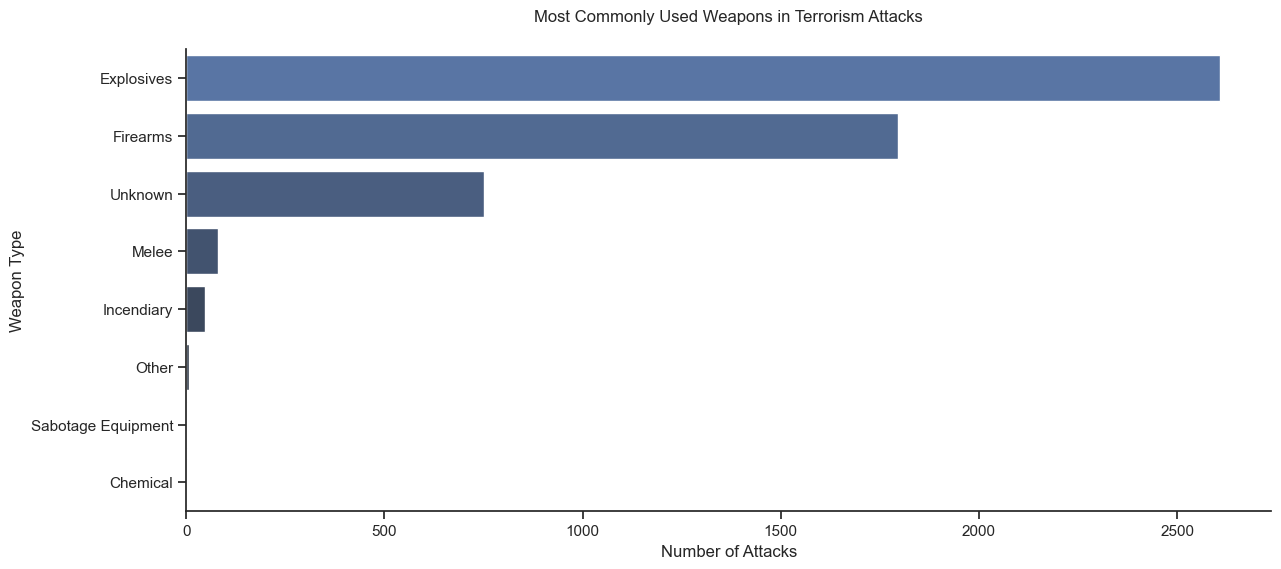

In [1573]:
# Visualization - Bar chart
plt.figure(figsize=(14, 6))
sns.barplot(x='count', y='weapon_type', data=weapon_counts.head(10), palette='dark:b_r')
plt.title('Most Commonly Used Weapons in Terrorism Attacks', pad=20)
plt.xlabel('Number of Attacks')
plt.ylabel('Weapon Type')
sns.despine()
plt.show()

- ### **What percentage of attacks use Explosives, Firearms or Others?** 

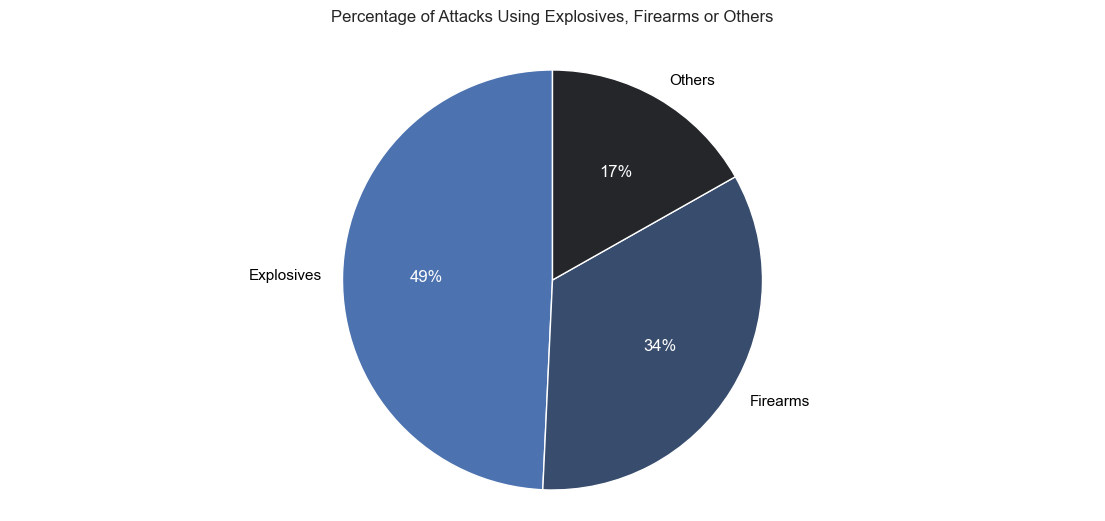

In [1574]:
# Define weapon categories
weapon_types = ['Explosives', 'Firearms', 'Other']

total_attacks = len(df)
explosive_attacks = len(df[df['weapon_type'] == 'Explosives'])

firearm_attacks = len(df[df['weapon_type'] == 'Firearms'])
other_attacks = total_attacks - (explosive_attacks + firearm_attacks)

sizes = [explosive_attacks, firearm_attacks, other_attacks]
labels = ['Explosives', 'Firearms', 'Others']

percentage_explosives = (explosive_attacks / total_attacks) * 100
percentage_firearms = (firearm_attacks / total_attacks) * 100
percentage_others = (other_attacks / total_attacks) * 100

# Visualization - Pie chart
plt.figure(figsize=(14, 6))
plt.pie(
    sizes, 
    labels=labels, 
    autopct='%1.0f%%', 
    startangle=90, 
    colors=sns.color_palette('dark:b_r', n_colors=3),
    textprops=dict(color='black')
)

plt.title('Percentage of Attacks Using Explosives, Firearms or Others', pad=20)
plt.axis('equal') 

for text in plt.gca().texts:
    if '%' in text.get_text(): 
        text.set_color('white')
plt.show()

- ### **Which weapons types and subtypes cause the most Casualties?**  

In [1575]:
# Group by weapon type and sum the total casualties
weapontype_casualties = df.groupby('weapon_type')['total_casualties'].sum().reset_index()
total_casualties_sum = weapontype_casualties['total_casualties'].sum()
weapontype_casualties.sort_values(by='total_casualties', ascending=False, inplace=True)

weapontype_casualties['percentage'] = (weapontype_casualties['total_casualties'] / total_casualties_sum * 100).round(0).astype(int).astype(str) + '%'
weapontype_casualties.columns = ['Weapon Type', 'Total Casualties', 'Percentage']
weapontype_casualties['Total Casualties'] = weapontype_casualties['Total Casualties'].astype(int)
weapontype_casualties.head(7)

,Weapon Type,Total Casualties,Percentage
1,Explosives,16796,66%
2,Firearms,5528,22%
7,Unknown,2651,10%
4,Melee,191,1%
3,Incendiary,45,0%
0,Chemical,42,0%
5,Other,8,0%


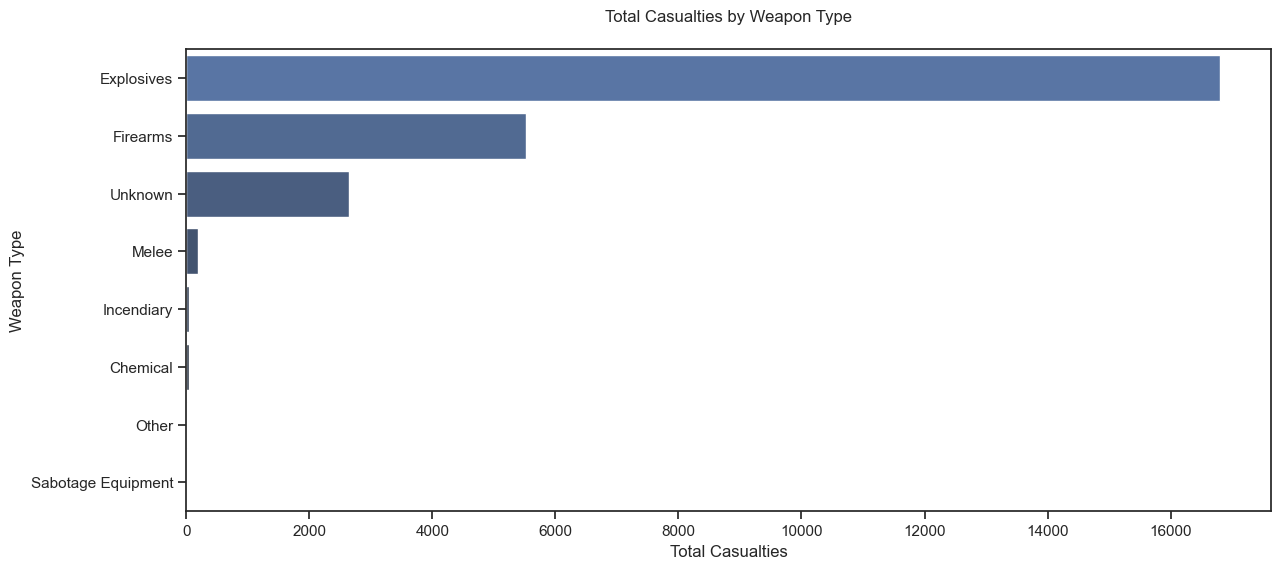

In [1576]:
# Visualization - Bar chart
plt.figure(figsize=(14, 6))
sns.barplot(data=weapon_casualties, x='Total Casualties', y='Weapon type', palette='dark:b_r')

plt.title('Total Casualties by Weapon Type', pad=20)
plt.xlabel('Total Casualties')
plt.ylabel('Weapon Type')
plt.show()

In [1577]:
# Group by weapon subtype and sum the total casualties
weaponsubtype_casualties = df.groupby('weapon_subtype')['total_casualties'].sum().reset_index()

weaponsubtype_casualties.sort_values(by='total_casualties', ascending=False, inplace=True)

weaponsubtype_casualties.columns = ['Weapon Subtype', 'Total Casualties']
weaponsubtype_casualties['Total Casualties'] = weaponsubtype_casualties['Total Casualties'].astype(int)

total_casualties = weaponsubtype_casualties['Total Casualties'].sum()
weaponsubtype_casualties['Casualty Percentage (%)'] = (weaponsubtype_casualties['Total Casualties'] / total_casualties * 100).round(0).astype(int).astype(str) + '%'
weaponsubtype_casualties.head(12)

,Weapon Subtype,Total Casualties,Casualty Percentage (%)
15,Suicide Vehicle,7009,31%
19,Unknown Gun Type,4436,20%
11,"Projectile (rockets, mortars, RPGs, etc.)",2957,13%
18,Unknown Explosive Type,1802,8%
7,Landmine,1785,8%
3,Grenade,1533,7%
16,Suicide Vest,834,4%
1,Automatic or Semi-Automatic Rifle,618,3%
4,Handgun,447,2%
12,Remote Trigger,433,2%


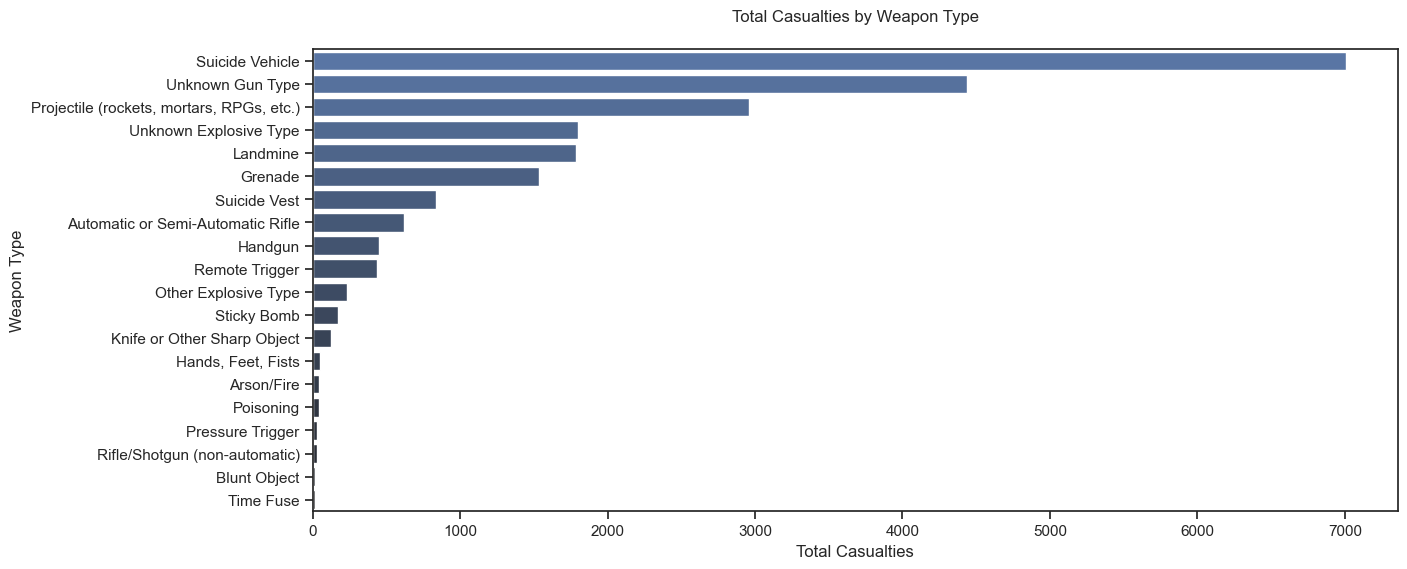

In [1578]:
# Visualization - Bar chart
plt.figure(figsize=(14, 6))
sns.barplot(data=weaponsubtye_casualties, x='Total Casualties', y='Weapon Subtype', palette='dark:b_r')

plt.title('Total Casualties by Weapon Type', pad=20)
plt.xlabel('Total Casualties')
plt.ylabel('Weapon Type')
plt.show()

- ### **What is the success rate for attacks using Firearms and Explosives?**  

In [1579]:
# Filter for attacks using Firearms and Explosives
firearms_attacks = df[df['weapon_type'] == 'Firearms']
explosives_attacks = df[df['weapon_type'] == 'Explosives']

firearms_total = len(firearms_attacks)
firearms_successful = firearms_attacks['success'].sum() 

explosives_total = len(explosives_attacks)
explosives_successful = explosives_attacks['success'].sum()

firearms_success_rate = (firearms_successful / firearms_total * 100) if firearms_total > 0 else 0
explosives_success_rate = (explosives_successful / explosives_total * 100) if explosives_total > 0 else 0

success_rates = pd.DataFrame({
    'Weapon Type': ['Firearms', 'Explosives'],
    'Success Rate (%)': [round(firearms_success_rate.astype(int)), round(explosives_success_rate.astype(int))]
})
success_rates

,Weapon Type,Success Rate (%)
0,Firearms,92
1,Explosives,81


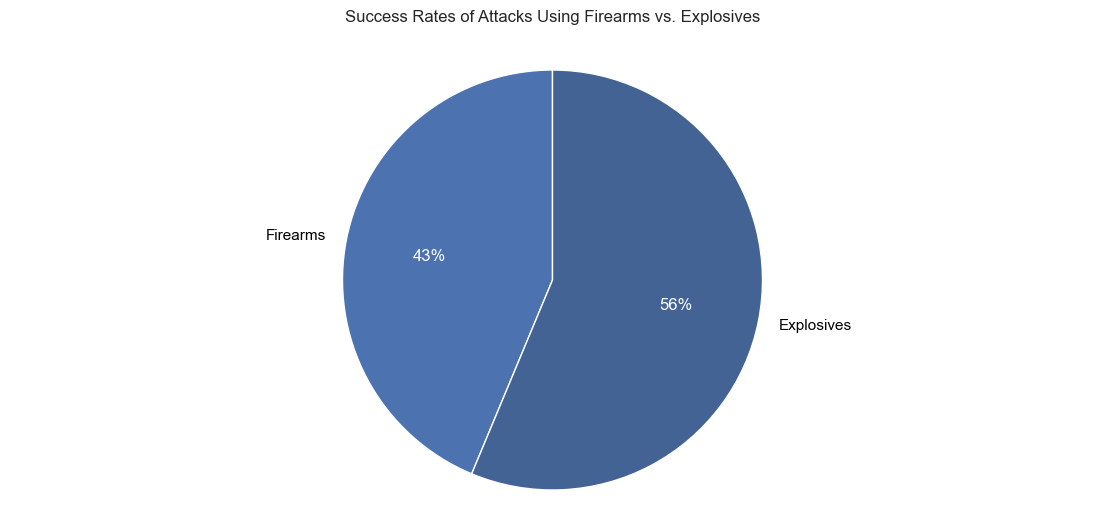

In [1580]:
# Set the Seaborn theme and palette
sns.set_theme(style='ticks')
palette = sns.color_palette('dark:b_r')

success_rates = pd.DataFrame({
    'Weapon Type': ['Firearms', 'Explosives'],
    'Total Attacks': [firearms_total, explosives_total],
    'Successful Attacks': [firearms_successful, explosives_successful],
    'Success Rate (%)': [round(firearms_success_rate), round(explosives_success_rate)]
})

labels = success_rates['Weapon Type']
sizes = success_rates['Successful Attacks']
colors = palette 

plt.figure(figsize=(14, 6))

def white_percent(pct):
    return f'{int(pct)}%' if pct > 0 else ''
wedges, texts, autotexts = plt.pie(sizes, labels=labels, autopct=white_percent, startangle=90, colors=colors)
for text in autotexts:
    text.set_color('white') 

plt.setp(texts, color='black') 
plt.title('Success Rates of Attacks Using Firearms vs. Explosives', pad=20)
plt.axis('equal')
plt.show()

- ### **Are suicide bombings more effective than other methods?**  

In [1581]:
# Filter for suicide and non-suicide attacks
suicide_attacks = df[df['suicide'] == 1]
non_suicide_attacks = df[df['suicide'] == 0]

suicide_total = len(suicide_attacks)
suicide_successful = suicide_attacks['success'].sum()  

non_suicide_total = len(non_suicide_attacks)
non_suicide_successful = non_suicide_attacks['success'].sum()

suicide_success_rate = (suicide_successful / suicide_total * 100) if suicide_total > 0 else 0
non_suicide_success_rate = (non_suicide_successful / non_suicide_total * 100) if non_suicide_total > 0 else 0

effectiveness_comparison = pd.DataFrame({
    'Attack Type': ['Suicide Bombings', 'Non-Suicide Attacks'],
    # 'Total Attacks': [suicide_total, non_suicide_total],
    # 'Successful Attacks': [suicide_successful, non_suicide_successful],
    # 'Success Rate (%)': [round(suicide_success_rate), round(non_suicide_success_rate)]
    'Success Rate (%)': [f"{round(suicide_success_rate)}%", f"{round(non_suicide_success_rate)}%"]

})

effectiveness_comparison

,Attack Type,Success Rate (%)
0,Suicide Bombings,96%
1,Non-Suicide Attacks,83%


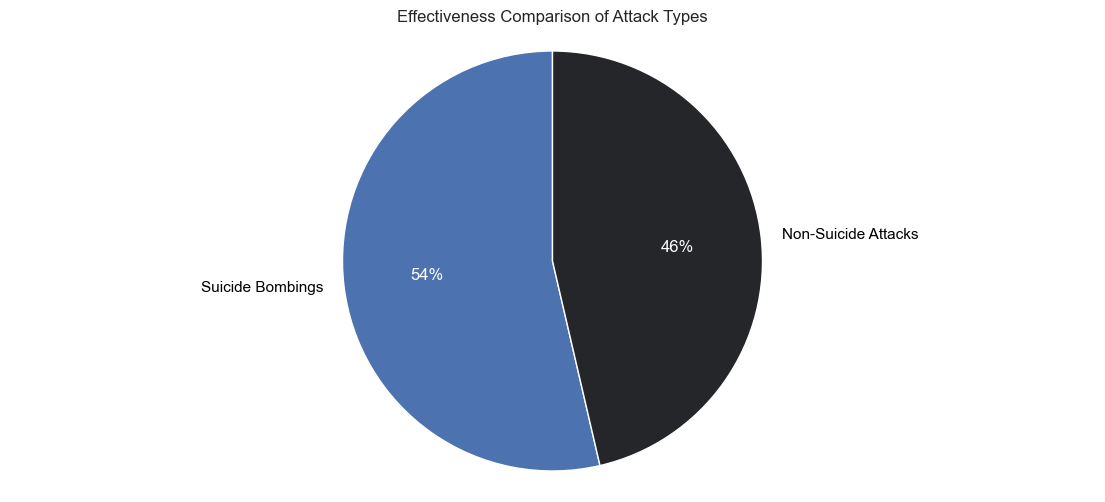

In [1582]:
# Prepare data for pie chart
sizes = [float(rate.strip('%')) for rate in effectiveness_comparison['Success Rate (%)']]
labels = effectiveness_comparison['Attack Type']

palette = sns.color_palette('dark:b_r', n_colors=len(labels))
plt.figure(figsize=(14, 6))
wedges, texts, autotexts = plt.pie(
    sizes, 
    labels=labels, 
    autopct='%1.0f%%', 
    startangle=90, 
    colors=palette
)

for text in texts:
    text.set_color('black')  # Set label text color
for autotext in autotexts:
    autotext.set_color('white')  # Set percentage text color

plt.title('Effectiveness Comparison of Attack Types')
plt.axis('equal')
plt.show()

In [1583]:
# Filter for explosive and non-explosive attacks
explosive_attacks = df[df['attack_type'] == 'Bombing/Explosion']
non_explosive_attacks = df[df['attack_type'] != 'Bombing/Explosion']

explosive_casualties = explosive_attacks['total_casualties'].sum()
non_explosive_casualties = non_explosive_attacks['total_casualties'].sum()

explosive_total = len(explosive_attacks)
non_explosive_total = len(non_explosive_attacks)

explosive_casualty_rate = (explosive_casualties / explosive_total) if explosive_total > 0 else 0
non_explosive_casualty_rate = (non_explosive_casualties / non_explosive_total) if non_explosive_total > 0 else 0

casualty_comparison = pd.DataFrame({
    'Attack Type': ['Explosive Attacks', 'Non-Explosive Attacks'],
    'Casualty Rate per Attack)': [round(explosive_casualty_rate), round(non_explosive_casualty_rate)]
})

casualty_comparison

,Attack Type,Casualty Rate per Attack)
0,Explosive Attacks,6
1,Non-Explosive Attacks,4


In [1584]:
# Filter for explosive and non-explosive attacks
explosive_attacks = df[df['attack_type'] == 'Bombing/Explosion']
non_explosive_attacks = df[df['attack_type'] != 'Bombing/Explosion']

explosive_casualties = explosive_attacks['total_casualties'].sum()
non_explosive_casualties = non_explosive_attacks['total_casualties'].sum()

total_casualties = explosive_casualties + non_explosive_casualties
explosive_casualty_percentage = (explosive_casualties / total_casualties * 100) if total_casualties > 0 else 0
non_explosive_casualty_percentage = (non_explosive_casualties / total_casualties * 100) if total_casualties > 0 else 0

casualty_comparison = pd.DataFrame({
    'Attack Type': ['Explosive Attacks', 'Non-Explosive Attacks'],
    'Casualty Percentage (%)': [f"{round(explosive_casualty_percentage)}%", f"{round(non_explosive_casualty_percentage)}%"]
})

casualty_comparison

,Attack Type,Casualty Percentage (%)
0,Explosive Attacks,54%
1,Non-Explosive Attacks,46%


- ### **What is the Correlation Between Attack Type and Weapon Used?**

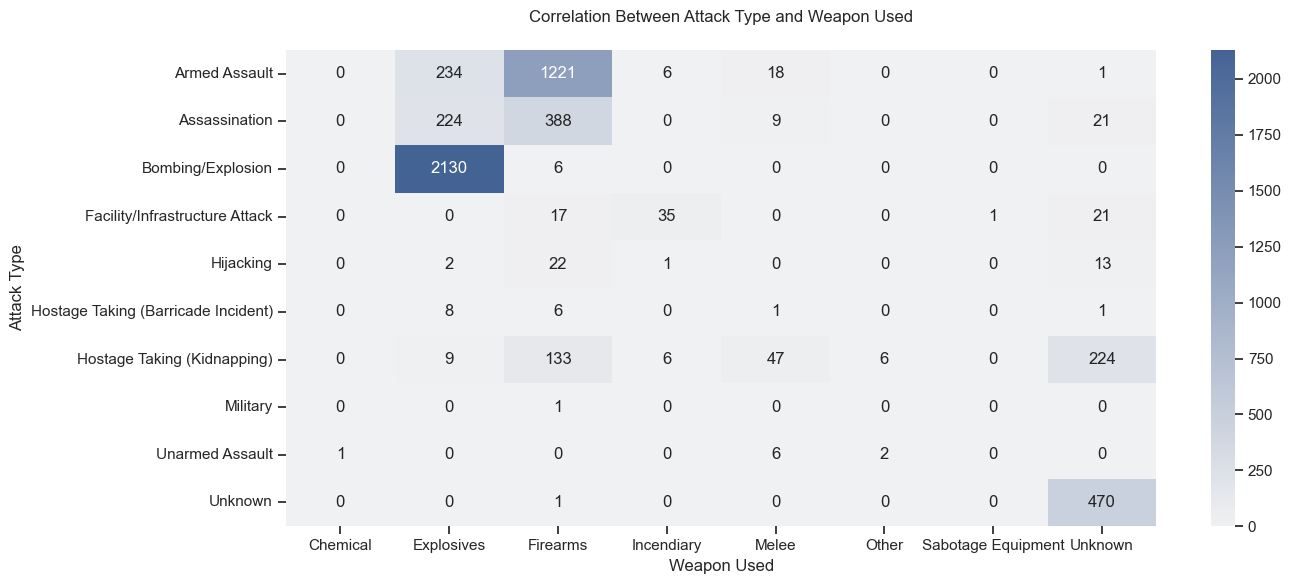

In [1585]:
# Set the Seaborn theme and color palette
sns.set_theme(style='ticks')
palette = sns.color_palette('dark:b_r')
attack_weapon_crosstab = pd.crosstab(df['attack_type'], df['weapon_type'])

cmap = sns.light_palette(palette[1], as_cmap=True)

plt.figure(figsize=(14, 6))
sns.heatmap(attack_weapon_crosstab, cmap=cmap, annot=True, fmt='d')
plt.title('Correlation Between Attack Type and Weapon Used', pad=20)
plt.xlabel('Weapon Used')
plt.ylabel('Attack Type')
plt.tight_layout()
plt.show()

- ### **What are the percentages of different weapon subtypes used in suicide attacks?**

In [1586]:
# Filter for suicide attacks
suicide_attacks = df[df['suicide'] == 1]

suicide_attack_counts = suicide_attacks['weapon_subtype'].value_counts().reset_index()
suicide_attack_counts.columns = ['Weapon Subtype', 'Count']
total_suicide_attacks = suicide_attack_counts['Count'].sum()

suicide_attack_counts['Percentage (%)'] = (suicide_attack_counts['Count'] / total_suicide_attacks) * 100
suicide_attack_counts['Percentage (%)'] = suicide_attack_counts['Percentage (%)'].round(0).astype(int).astype(str) + '%'

suicide_attack_counts = suicide_attack_counts[['Weapon Subtype', 'Percentage (%)']]
suicide_attack_counts

,Weapon Subtype,Percentage (%)
0,Suicide Vehicle,74%
1,Suicide Vest,26%


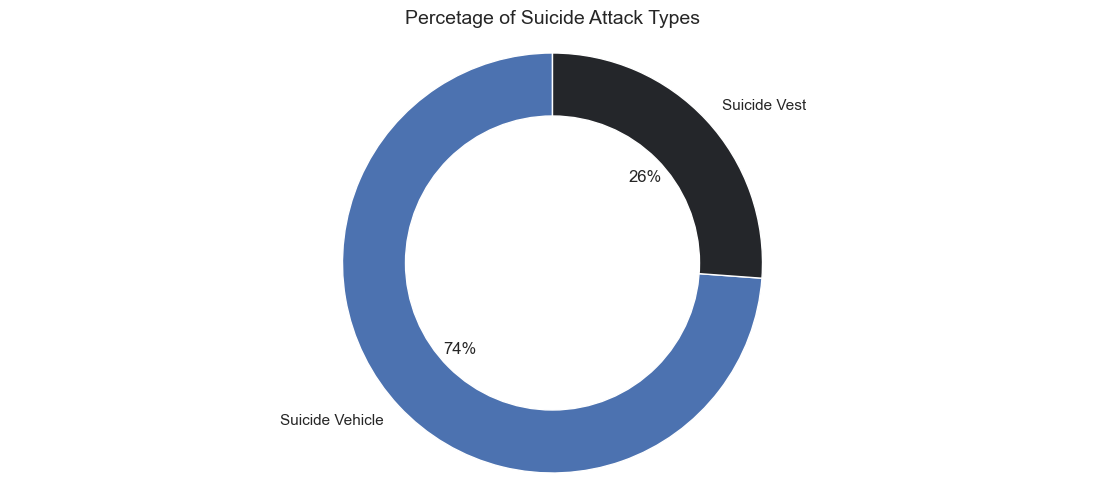

In [1587]:
sns.set_theme(style='ticks')
palette = 'dark:b_r'

suicide_attacks = df[df['suicide'] == 1]
weapon_counts = suicide_attacks['weapon_subtype'].value_counts()
weapon_percentages = (weapon_counts / weapon_counts.sum()) * 100

plt.figure(figsize=(14, 6))
plt.pie(weapon_percentages, labels=weapon_percentages.index, 
        autopct='%1.0f%%', startangle=90, 
        colors=sns.color_palette(palette, len(weapon_percentages)))

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Percetage of Suicide Attack Types', fontsize=14)
plt.axis('equal') 
plt.show()

- ### **What are the percentages of weapon subtypes used in assassination attacks?**

In [1588]:
# Filter for assassination attacks
assassination_attacks = df[df['attack_type'] == 'Assassination']
weapon_subtype_counts = assassination_attacks['weapon_subtype'].value_counts().reset_index()
weapon_subtype_counts.columns = ['Weapon Subtype', 'Count']

total_assassination_attacks = weapon_subtype_counts['Count'].sum()
weapon_subtype_counts['Percentage (%)'] = (weapon_subtype_counts['Count'] / total_assassination_attacks) * 100
weapon_subtype_counts['Percentage (%)'] = (
    weapon_subtype_counts['Percentage (%)']
    .round(0)
    .astype(int)
    .astype(str) + '%'
)

percentage_distribution = weapon_subtype_counts[['Weapon Subtype', 'Percentage (%)']]
percentage_distribution.head(12)

,Weapon Subtype,Percentage (%)
0,Unknown Gun Type,33%
1,Handgun,23%
2,Landmine,7%
3,Unknown Explosive Type,6%
4,Automatic or Semi-Automatic Rifle,6%
5,Grenade,6%
6,Sticky Bomb,5%
7,Suicide Vehicle,5%
8,"Projectile (rockets, mortars, RPGs, etc.)",2%
9,Remote Trigger,2%


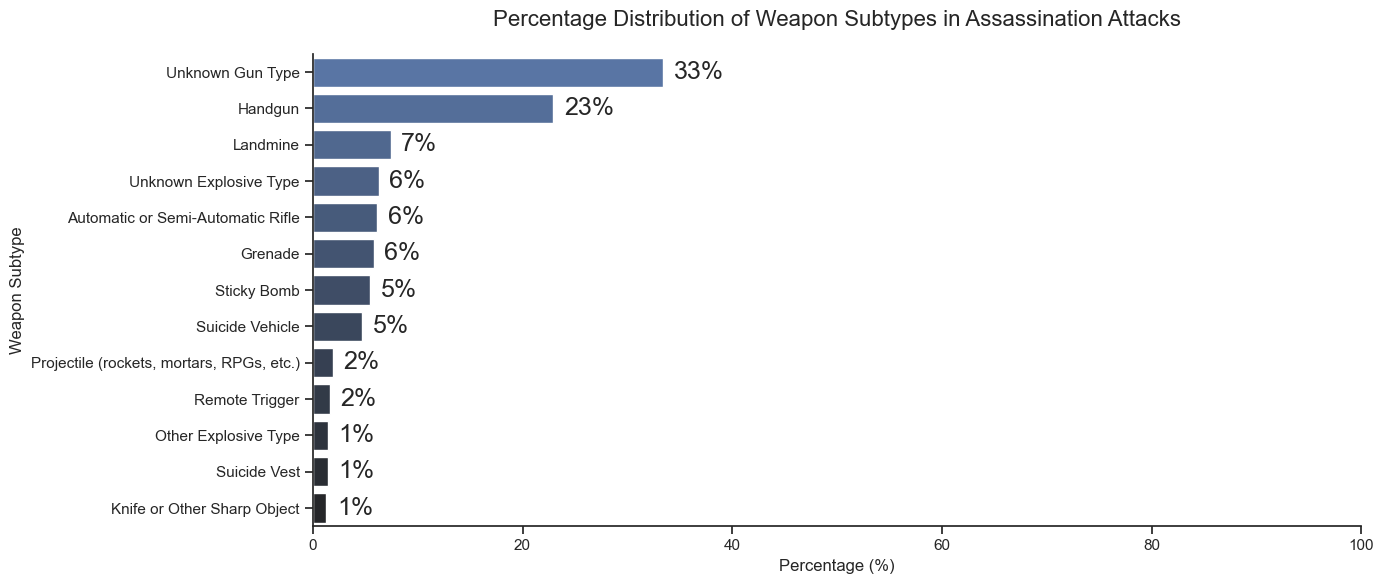

In [1589]:
# Set the Seaborn theme
sns.set_theme(style='ticks')
palette = 'dark:b_r'

assassination_attacks = df[df['attack_type'] == 'Assassination']
weapon_counts = assassination_attacks['weapon_subtype'].value_counts().head(13)

weapon_percentages = (weapon_counts / weapon_counts.sum()) * 100
plt.figure(figsize=(14, 6))
sns.barplot(y=weapon_percentages.index, x=weapon_percentages.values, palette=palette)
plt.title('Percentage Distribution of Weapon Subtypes in Assassination Attacks', pad=20, fontsize=16)
plt.ylabel('Weapon Subtype')
plt.xlabel('Percentage (%)')
plt.xlim(0, 100) 

for index, value in enumerate(weapon_percentages):
    plt.text(value + 1, index, f"{value:.0f}%", ha='left', va='center', fontsize=18)
plt.tight_layout() 
sns.despine()
plt.show()

### **7. Casualty Analysis**

- ### **What are the total casualties by region and city?** 

In [1590]:
region_city_killed = df.groupby(['region', 'city'])['killed'].sum().reset_index()
region_city_killed.columns = ['Region', 'City', 'Total Died']
region_city_killed['Total Died'] = region_city_killed['Total Died'].astype(int)
region_city_killed = region_city_killed.sort_values(by='Total Died', ascending=False)
region_city_killed.head(10)

,Region,City,Total Died
38,Banaadir,Mogadishu,4939
174,Jubbada Hoose,Kismaayo,606
3,Baay,Baydhaba,492
258,Shabeellaha Hoose,Afgooye,400
104,Hiiraan,Beledweyne,375
100,Gedo,Garbahaareey,253
201,Mudug,Gaalkacyo,242
108,Hiiraan,Buulabarde,196
34,Bakool,Xuddur,188
303,Shabeellaha Hoose,Qoryooleey,184


In [1591]:
region_city_injured = df.groupby(['region', 'city'])['wounded'].sum().reset_index()
region_city_injured.columns = ['Region', 'City', 'Total Injured']
region_city_injured['Total Injured'] = region_city_injured['Total Injured'].astype(int)
region_city_injured = region_city_injured.sort_values(by='Total Injured', ascending=False)
region_city_injured.head(10)

,Region,City,Total Injured
38,Banaadir,Mogadishu,6088
3,Baay,Baydhaba,587
174,Jubbada Hoose,Kismaayo,471
201,Mudug,Gaalkacyo,329
43,Bari,Boosaaso,309
104,Hiiraan,Beledweyne,290
258,Shabeellaha Hoose,Afgooye,232
34,Bakool,Xuddur,171
100,Gedo,Garbahaareey,128
8,Baay,Buurhakaba,114


In [1592]:
total_casualties_by_region_city = df.groupby(['region', 'city'])['total_casualties'].sum().reset_index()
total_casualties_by_region_city.columns = ['Region', 'City', 'Total Casualties']
total_casualties_by_region_city['Total Casualties'] = total_casualties_by_region_city['Total Casualties'].astype(int)
total_casualties_by_region_city = total_casualties_by_region_city.sort_values(by='Total Casualties', ascending=False)
total_casualties_by_region_city.head(10)

,Region,City,Total Casualties
38,Banaadir,Mogadishu,11027
3,Baay,Baydhaba,1079
174,Jubbada Hoose,Kismaayo,1077
104,Hiiraan,Beledweyne,665
258,Shabeellaha Hoose,Afgooye,632
201,Mudug,Gaalkacyo,571
43,Bari,Boosaaso,476
100,Gedo,Garbahaareey,381
34,Bakool,Xuddur,359
13,Baay,Goof Guduud,283


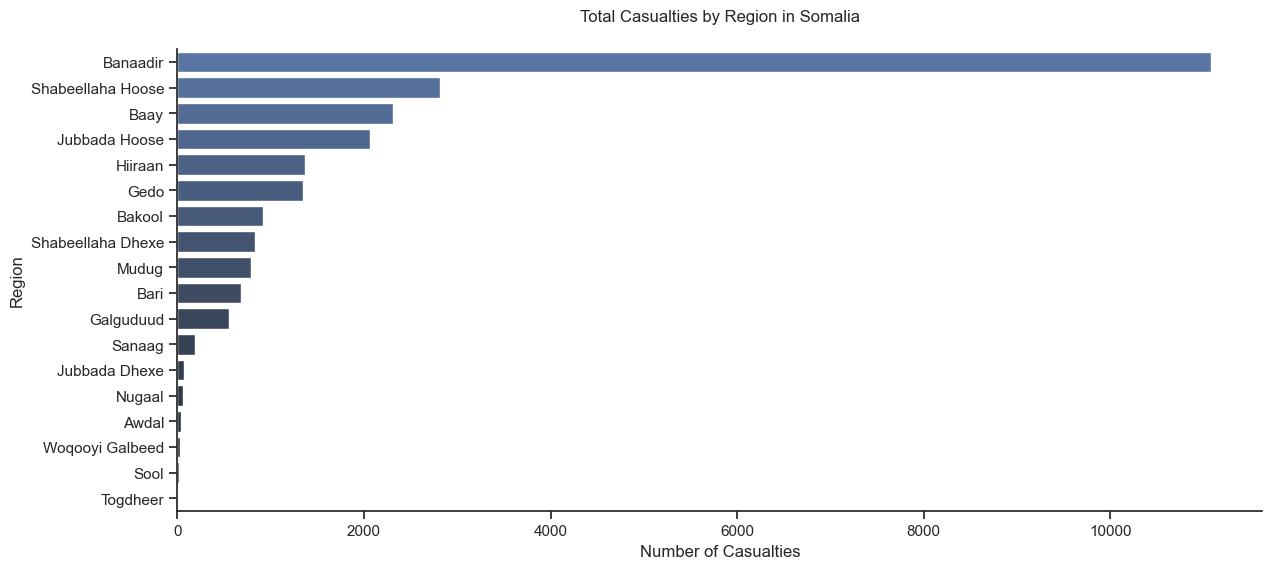

In [1593]:
# Set the Seaborn theme and palette
sns.set_theme(style='ticks')
palette = 'dark:b_r'

df_reg = df[df['region'] != 'Unknown']

region_casualties = df_reg.groupby('region')['total_casualties'].sum().reset_index().sort_values(by='total_casualties', ascending=False)
plt.figure(figsize=(14, 6))
sns.barplot(x='total_casualties', y='region', data=region_casualties, palette=palette)

plt.title('Total Casualties by Region in Somalia', pad=20)
plt.xlabel('Number of Casualties')
plt.ylabel('Region')
plt.xticks(rotation=0)
sns.despine()
plt.show()

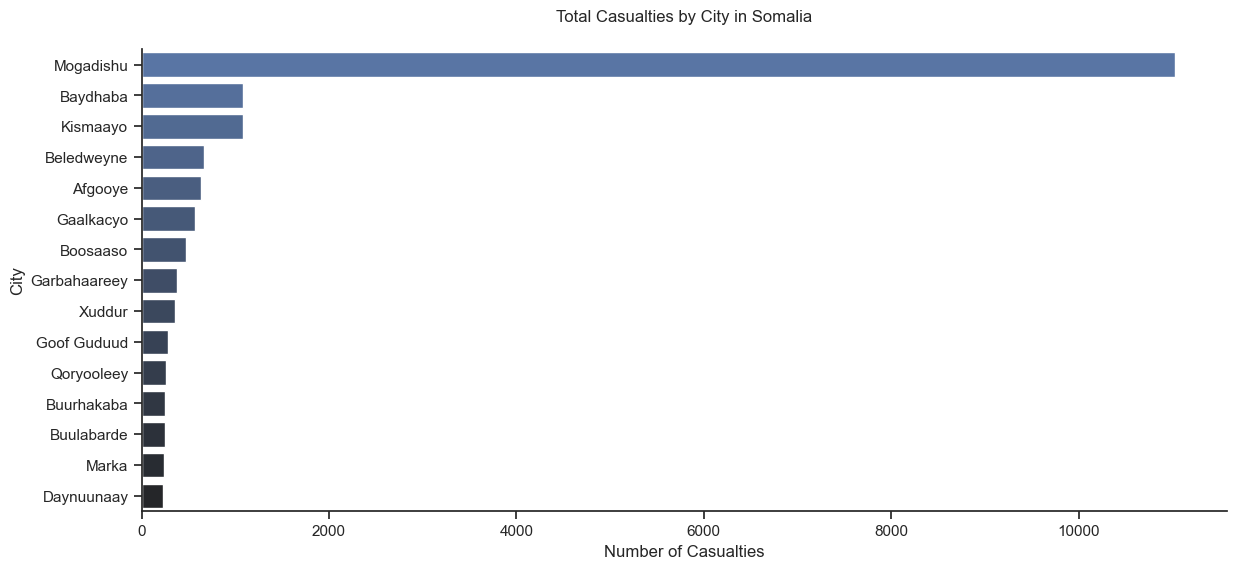

In [1594]:
# Set the Seaborn theme and palette
sns.set_theme(style='ticks')
palette = 'dark:b_r'
df_cit = df[df['city']!= 'Unknown']

city_casualties = df_cit.groupby('city')['total_casualties'].sum().reset_index().sort_values(by='total_casualties', ascending=False)
city_casualties = city_casualties.head(15)

plt.figure(figsize=(14, 6))

sns.barplot(x='total_casualties', y='city', data=city_casualties, palette=palette)
plt.title('Total Casualties by City in Somalia', pad=20)
plt.xlabel('Number of Casualties')
plt.ylabel('City')
plt.xticks(rotation=0)
sns.despine()
plt.show()

- ### **What percentage of attacks resulted in casualties compared to those that did not?**

In [1595]:
# Count the total number of attacks
total_attacks = df.shape[0]

attacks_with_casualties = df[df['total_casualties'] > 0].shape[0]
attacks_without_casualties = total_attacks - attacks_with_casualties

percentage_with_casualties = round((attacks_with_casualties / total_attacks) * 100)
percentage_without_casualties = round((attacks_without_casualties / total_attacks) * 100)

casualty_summary = pd.DataFrame({
    'Casualty Status': ['Attacks with Casualties', 'Attacks with no Casualties'],
    'Percentage (%)': [f"{percentage_with_casualties}%", f"{percentage_without_casualties}%"]
})

casualty_summary

,Casualty Status,Percentage (%)
0,Attacks with Casualties,84%
1,Attacks with no Casualties,16%


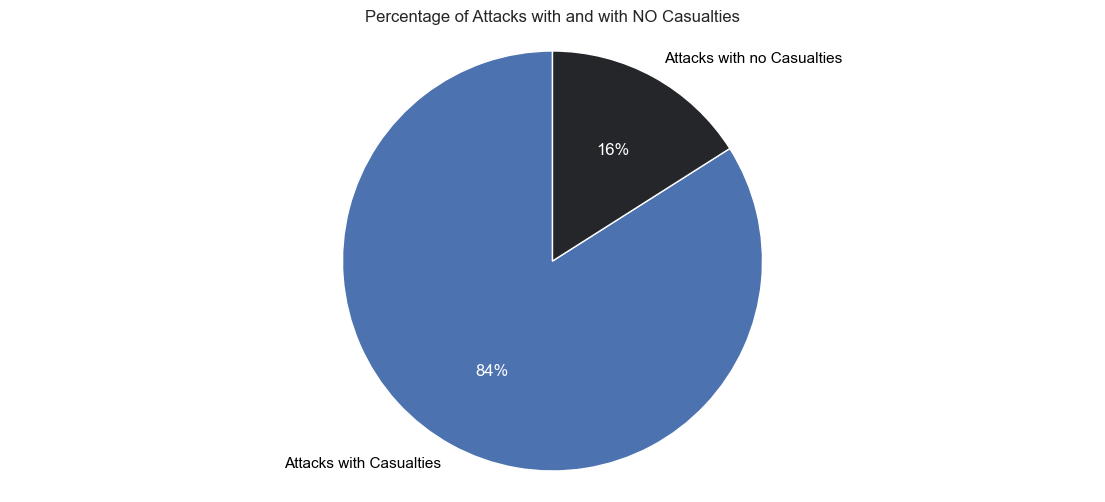

In [1596]:
# Set the Seaborn theme and palette
sns.set_theme(style='ticks')

labels = casualty_summary['Casualty Status']
sizes = [percentage_with_casualties, percentage_without_casualties]
colors = sns.color_palette("dark:b_r", n_colors=len(labels)) 
plt.figure(figsize=(14, 6))
wedges, texts, autotexts = plt.pie(sizes, labels=labels, autopct='%1.0f%%', startangle=90, colors=colors)
for text in texts:
    text.set_color('black')
for autotext in autotexts:
    autotext.set_color('white')
plt.axis('equal')
plt.title('Percentage of Attacks with and with NO Casualties', fontsize=12)
plt.show()

- ### **Are there any notable terrorism incidents with significant casualties?**

In [1597]:
high_casualty_threshold = 10
notable_attacks_high_casualties = df[df['total_casualties'] > high_casualty_threshold]
notable_attacks_summary = notable_attacks_high_casualties[['date', 'total_casualties']]
notable_attacks_summary['total_casualties'] = notable_attacks_summary['total_casualties'].astype(int)
notable_attacks_summary = notable_attacks_summary.sort_values(by='total_casualties', ascending=False)
notable_attacks_summary.head(10)

,date,total_casualties
4020,2017-10-14,904
911,2011-10-04,268
5031,2019-12-28,232
622,2009-10-13,200
123,1995-08-26,172
4718,2019-02-28,157
2946,2016-01-15,142
374,2008-02-05,121
212,2007-02-19,113
3175,2016-06-09,111


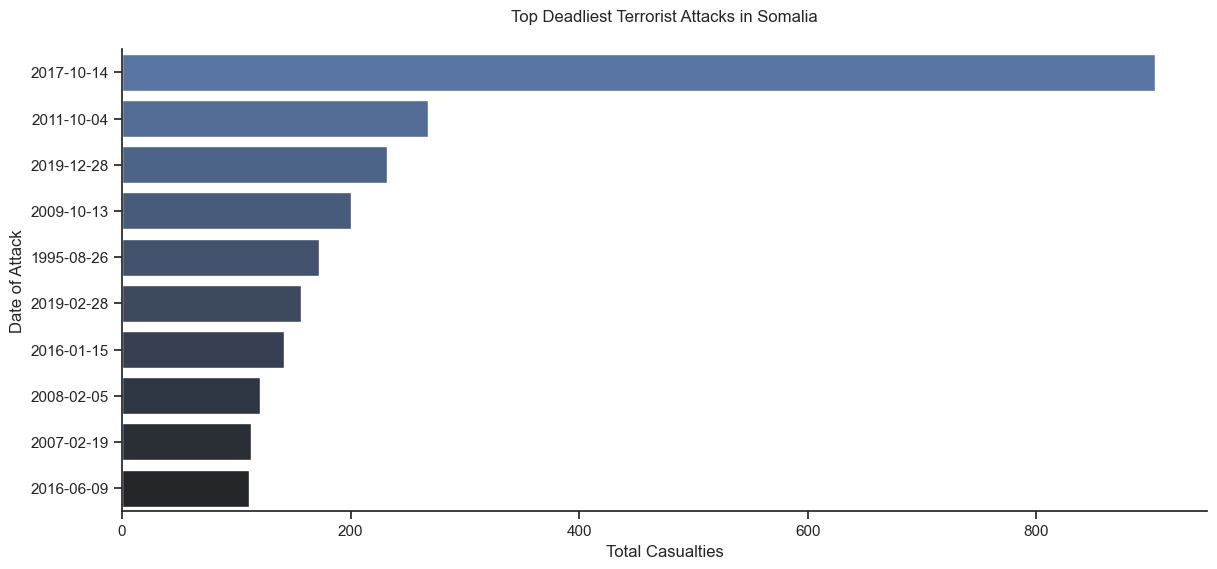

In [1598]:
sns.set_theme(style='ticks')
palette = 'dark:b_r'

deadliest_attacks = df[['eventid', 'date', 
                        'city', 'region', 'total_casualties']].sort_values(by='total_casualties', 
                                                                           ascending=False).head(10)
plt.figure(figsize=(14, 6))
sns.barplot(data=deadliest_attacks, x='total_casualties', y='date', palette=palette)
plt.title('Top Deadliest Terrorist Attacks in Somalia', pad=20)
plt.xlabel('Total Casualties')
plt.ylabel('Date of Attack')
sns.despine()
plt.show()

- ### **Which terrorism incidents caused the most deaths and injuries?**

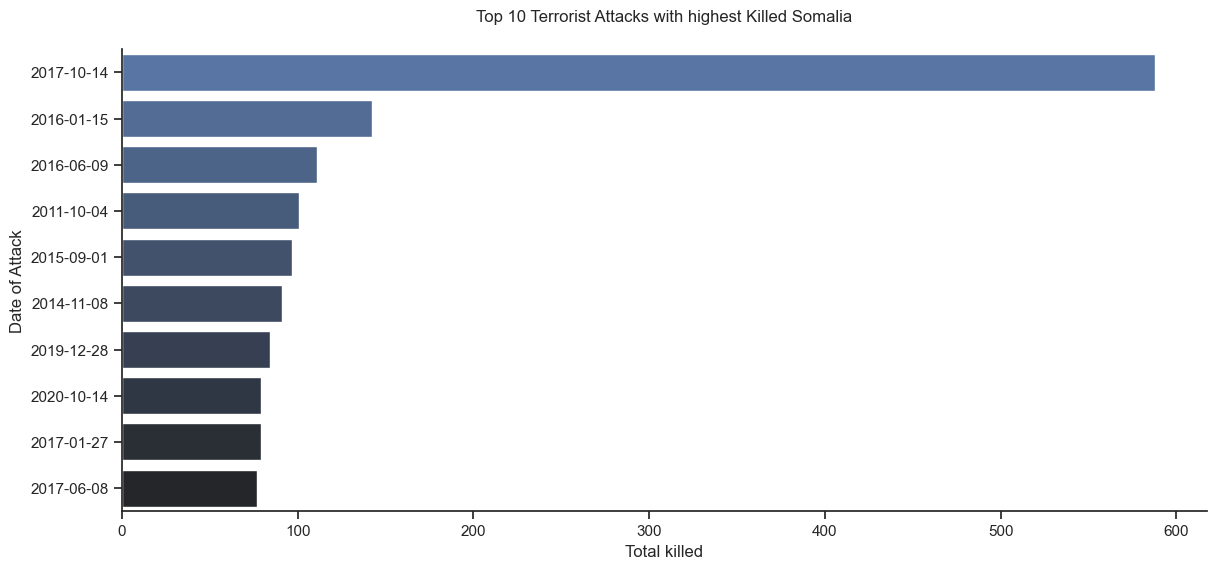

In [1599]:
sns.set_theme(style='ticks')
palette = 'dark:b_r'

deadliest_attacks = df[['eventid', 'date', 
                        'city', 'region', 'killed']].sort_values(by='killed', 
                                                                           ascending=False).head(10)

plt.figure(figsize=(14, 6))
sns.barplot(data=deadliest_attacks, x='killed', y='date', palette=palette)
plt.title('Top 10 Terrorist Attacks with highest Killed Somalia', pad=20)
plt.xlabel('Total killed')
plt.ylabel('Date of Attack')
sns.despine()
plt.show()

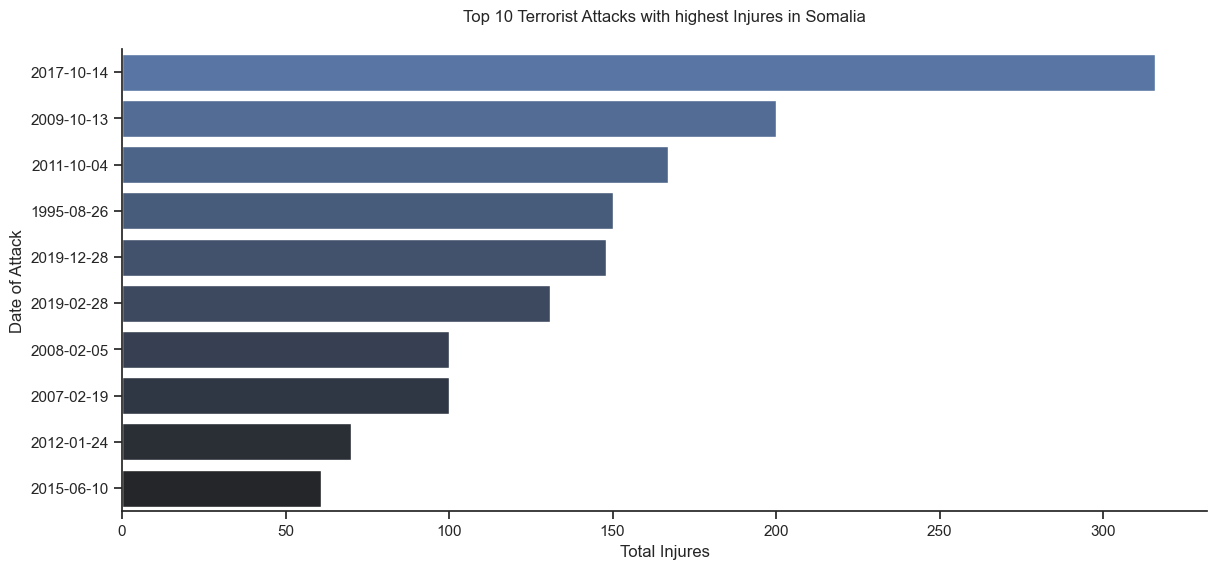

In [1600]:
sns.set_theme(style='ticks')
palette = 'dark:b_r'

deadliest_attacks = df[['eventid', 'date', 
                        'city', 'region', 'wounded']].sort_values(by='wounded', 
                                                                           ascending=False).head(10)

plt.figure(figsize=(14, 6))
sns.barplot(data=deadliest_attacks, x='wounded', y='date', palette=palette)
plt.title('Top 10 Terrorist Attacks with highest Injures in Somalia', pad=20)
plt.xlabel('Total Injures')
plt.ylabel('Date of Attack')
sns.despine()
plt.show()

- ### **Which hotels in Mogadishu have been most frequently targeted?**

In [1601]:
hotels_targeted = df[df['target_subtype'] == 'Hotel/Resort']
hotel_attack_counts = hotels_targeted['target'].value_counts() 
most_targeted_hotels = hotel_attack_counts.reset_index()
most_targeted_hotels.columns = ['Hotel', 'Number of Attacks']
most_targeted_hotels = most_targeted_hotels.sort_values(by='Number of Attacks', ascending=False)
most_targeted_hotels_df = most_targeted_hotels.head(10)
most_targeted_hotels_df


,Hotel,Number of Attacks
0,Makkah Al-Mukarama Hotel,6
1,The Village Hotel,6
2,Wehliye Hotel,4
3,SYL Hotel,4
4,Sahafi Hotel,3
5,Madina Hotel,2
6,Jazeera Palace Hotel,2
7,Nasa Hablod Hotel,2
26,Kulmiye Hotel,1
22,Ramadan Hotel,1


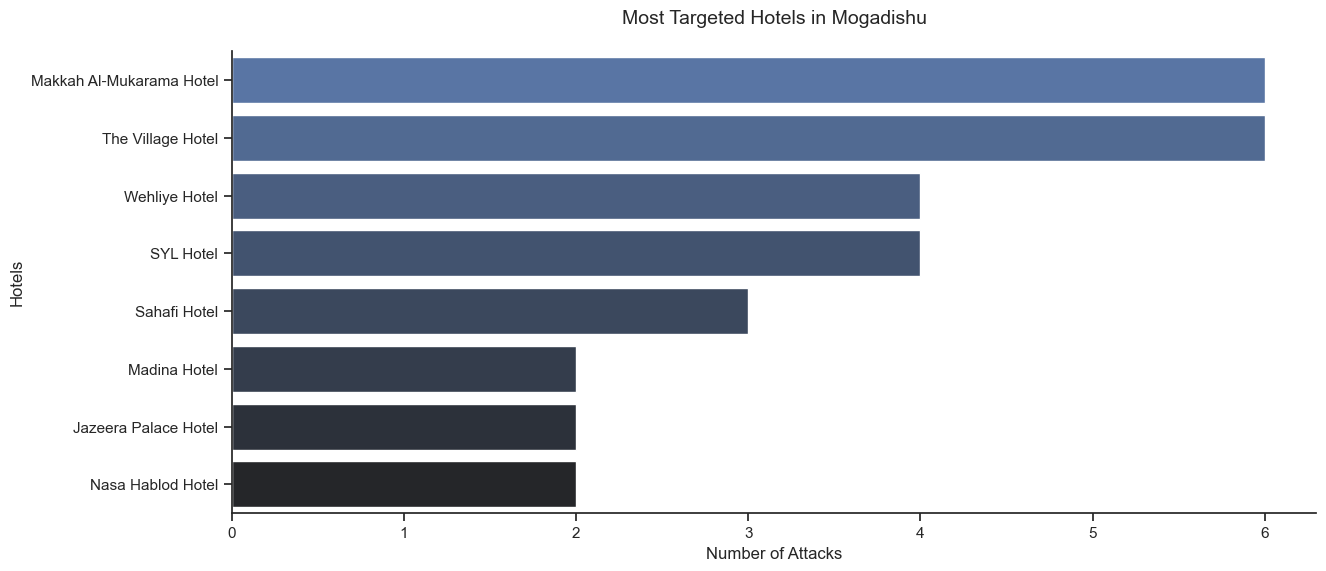

In [1602]:
sns.set_theme(style='ticks')
palette = 'dark:b_r'
# Filter the DataFrame for attacks targeting hotels
hotel_attacks = df[df['target_subtype'] == 'Hotel/Resort']

# Count attacks by region (state or city)
vulnerable_regions = hotel_attacks['target'].value_counts().head(8)  # Change 'state' to 'city' if needed

# Visualization: Bar chart of vulnerable regions
plt.figure(figsize=(14, 6))
sns.barplot(x=vulnerable_regions.values, y=vulnerable_regions.index, palette=palette)
plt.title('Most Targeted Hotels in Mogadishu', pad=20, fontsize=14)
plt.xlabel('Number of Attacks')
plt.ylabel('Hotels')
sns.despine()
plt.show()